# 0.0 IMPORTS

In [78]:
import inflection
import math
import datetime
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as GridSpec

from IPython.display       import HTML
from IPython.display       import Image
from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy                 import stats         as ss

## 0.2 Helper Functions

In [2]:
def cramer_v ( x, y ):
    '''# Etapas do V de Cramer
    # Encontrando a quantidade do 1 contra 1 das variáveis
    cm = pd.crosstab( a['state_holiday'], a['store_type'] ).values

    # Calculando V de Cramer. Fórmula: V = sqrt ((x2/n)/ min(r-1,k-1)).
    # sqrt: raiz quadrada
    # x2 é derivado do teste de qui-quadrado de pearson
    # n é o total geral de observações
    # r é o número de colunas
    # k é o número de linhas

    # Encontrando o qui-quadrado
    chi2 = ss.chi2_contingency( cm )[0]

    # Encontrando o n
    n = cm.sum()

    # Encontrando o r e o k
    r, k = cm.shape

    # V de Cramer. Ele vai de 0 a 1. Quanto mais perto de 0 menor a correlação. Quanto mais próximo de 1 mais forte a correlação.
    v = np.sqrt( (chi2/n) / ( min( k-1, r-1 ) ) )'''
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge (Unindo os arquivos a partir do store, coluna comun aos dois arquivoc, a fim de montar um tabelão com os dados de venda e as características da loja. LEmbre-se da união de tabelas no SQL)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRIÇÃO DOS DADOS (Passo 1)

In [5]:
# Cópia do DF - neste caso o meigraom fez pois não precisar rodar o código completo se der algum erro, apenas a seção
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Renomeando as colunas com a função lambda

snakecase = lambda x: inflection.underscore(x)
# map vai mapear a função snakecase em todas as palavras da lista cols_old
cols_new = list ( map( snakecase, cols_old ) )

# rename 
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Columns: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
# alterando o tipo da coluna data de object para date
df1['date'] = pd.to_datetime( df1 ['date'] )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
# somando as linhas vazias

df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance: distancia até um competidor          
# max_value 20000 if math.isna(df1['competition_distance']) else df1 ['competition_distance'] - raciocínio
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month: data da última competição. Para os NA's copiar data da última venda
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
                       
# promo2_since_week: data da continuidade da última promoção
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year     
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval: intervalo de meses em que apromoção 2 foi ativa. A ideia é criar uma coluna auxiliar dizendo sim ou não.
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0 , inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] ==0 else 1 if x['month_map'] in x['promo_interval'].split ( ',' ) else 0, axis=1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [12]:
df1.sample(10).T

,790899,763150,140369,641332,985428,521531,174529,901757,978914,625955
store,35,161,995,993,554,497,590,508,730,111
day_of_week,1,5,6,3,2,5,3,7,1,2
date,2013-07-22 00:00:00,2013-08-16 00:00:00,2015-03-28 00:00:00,2013-12-04 00:00:00,2013-01-29 00:00:00,2014-03-21 00:00:00,2015-02-25 00:00:00,2013-04-14 00:00:00,2013-02-04 00:00:00,2013-12-17 00:00:00
sales,7117,6556,8683,10912,3227,8919,3074,0,12198,10877
customers,614,785,737,929,452,1153,269,0,1401,807
open,1,1,1,1,1,1,1,0,1,1
promo,0,1,0,1,0,1,0,0,1,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,1,1,0,0,0,0,0,0,1,0
store_type,d,a,d,d,c,a,d,a,c,d


## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [14]:
# Separando as colunas númericas
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [15]:
# Central Tendence
ct1 = pd.DataFrame( num_attributes.apply ( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median) ).T

# Dispercion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply ( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply (min) ).T
d3 = pd.DataFrame( num_attributes.apply (max) ).T
d4 = pd.DataFrame( num_attributes.apply (lambda x: (x.max() - x.min()) ) ).T
d5 = pd.DataFrame( num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame( num_attributes.apply (lambda x: x.kurtosis () ) ).T


#Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'atributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


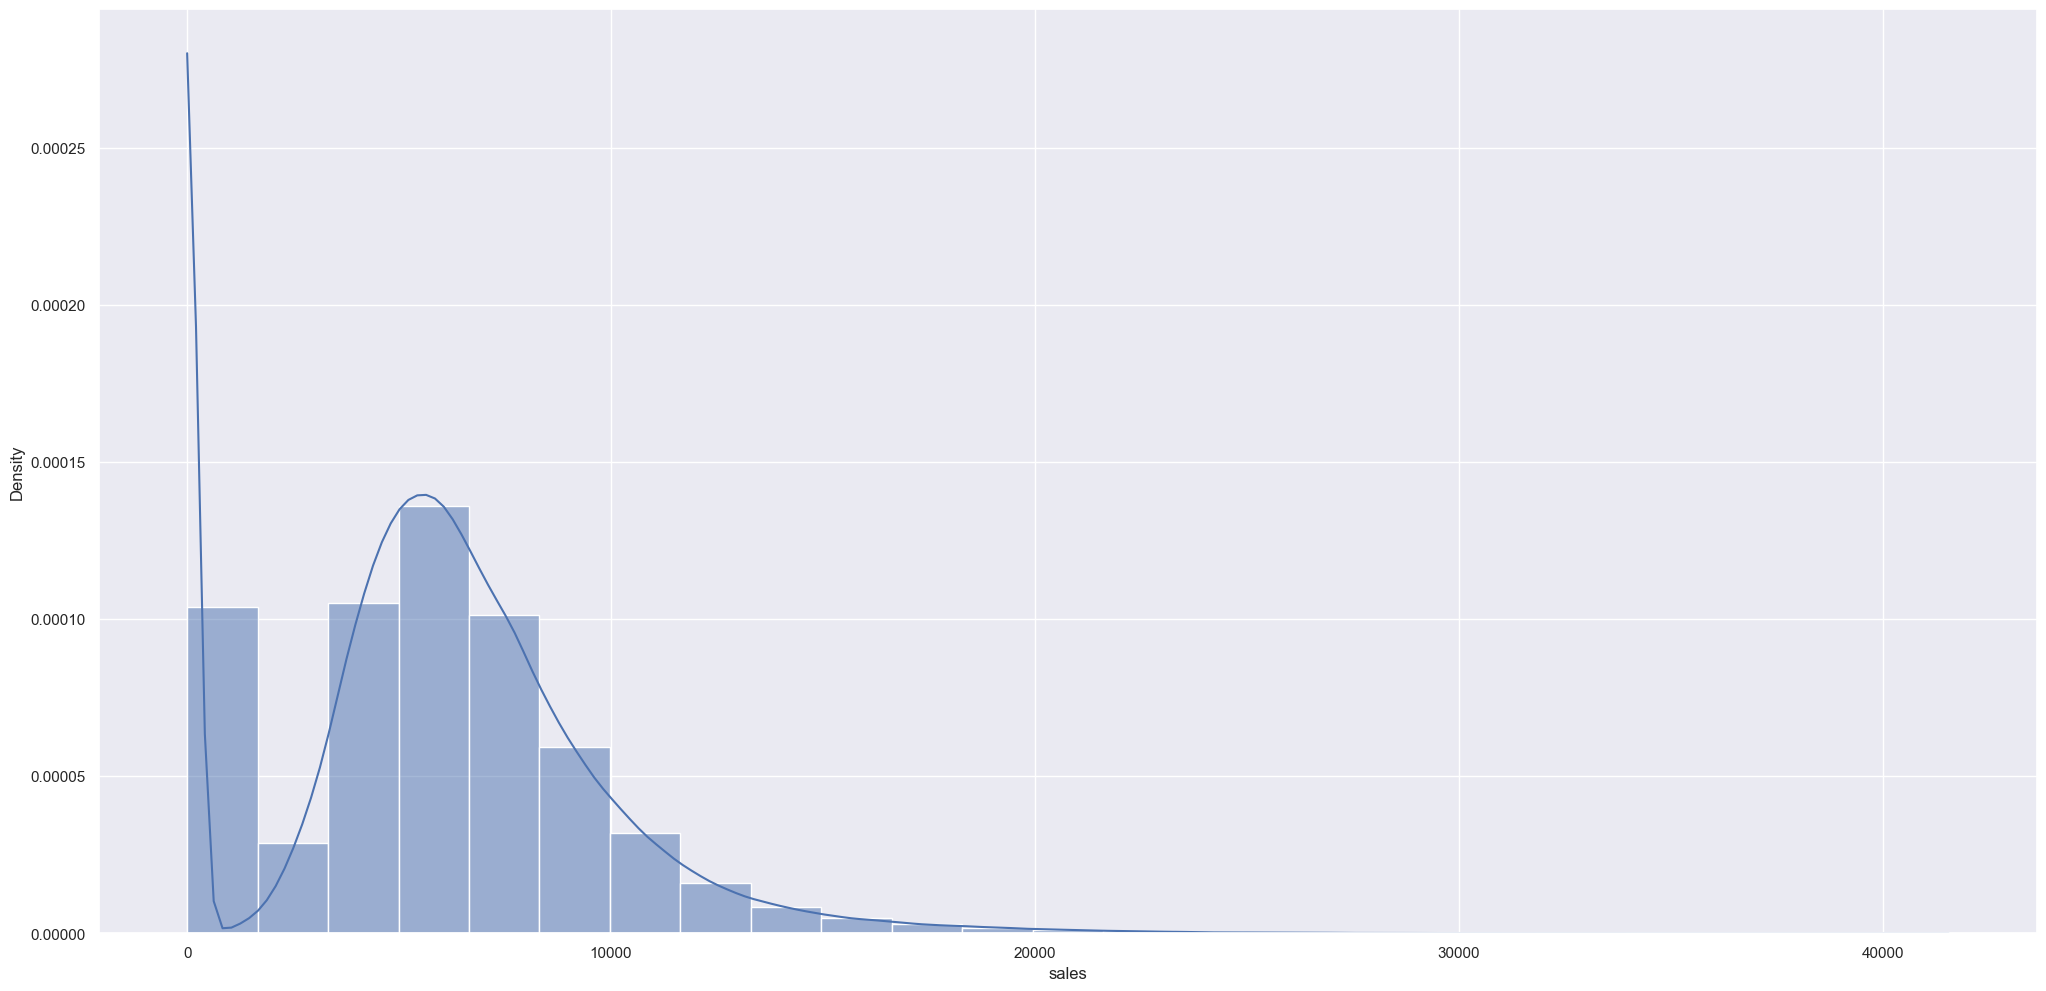

In [16]:
sns.histplot( df1['sales'], kde=True, stat="density" , bins=25 );

## 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

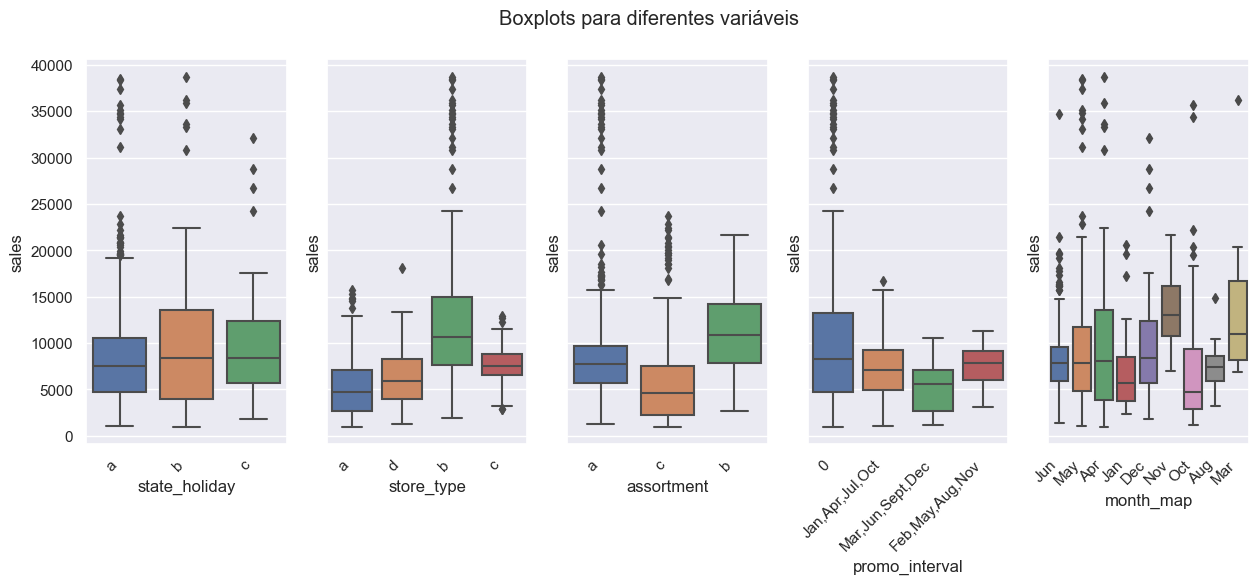

In [18]:
# Filtrando o dataset
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

# Configuração do subplot
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Boxplots
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='promo_interval', y='sales', data=aux1, ax=axes[3])
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='month_map', y='sales', data=aux1, ax=axes[4])
axes[4].set_xticklabels(axes[4].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

# Ajusta o título do subplot
plt.suptitle('Boxplots para diferentes variáveis')

# Exibe o gráfico
plt.show()


# 2.0 FEATURE ENGINEERING (Passo 2)

In [19]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

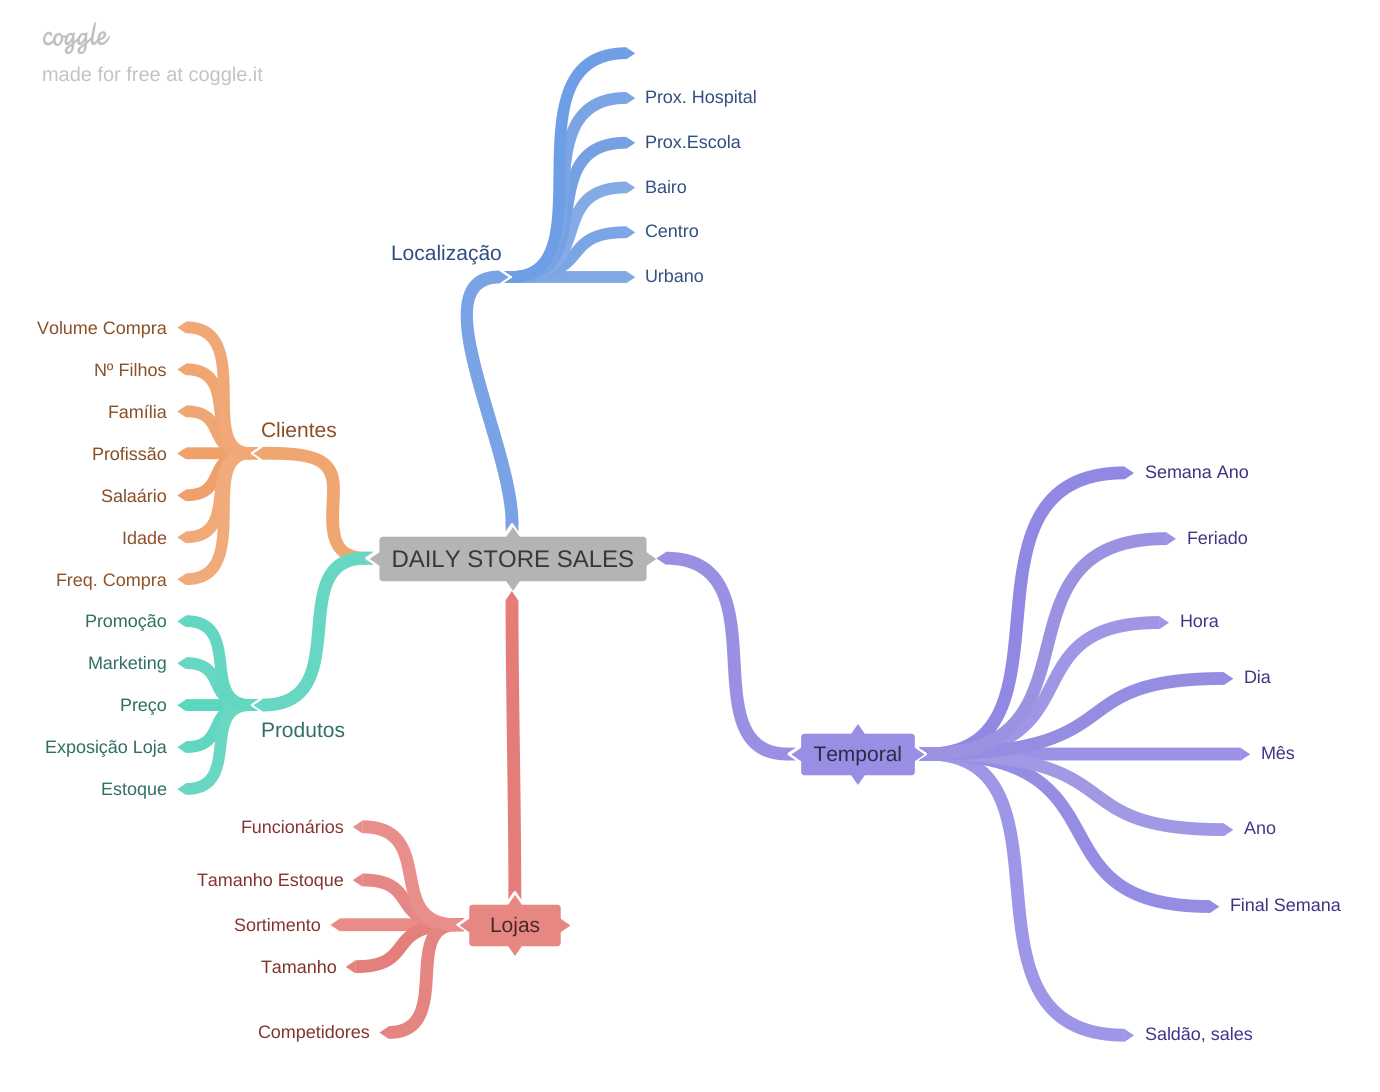

In [20]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com estoque maior deveriam vender mais.

**3.** Lojas com maior sortimento deveriam vender mais.

**4.** Lojas maiores deveriam vender mais.

**5.** Lojas com menos competidores devereiam vender menos.

### 2.2.2 Hipóteses do Produto

**1.** Lojas com promoções deveriam vender mais.

**2.** Lojas que investem em marketing deveriam vender mais.

**3.** Lojas com produtos mais caros deveriam vender menos.

**4.** Lojas com produtos mais expostos vendem mais.

**5.** Lojas com poucos produtos em estoque deveriam vender menos.

**6.** Lojas com produtos mais baratos por mais tempos deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primieros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas com funcionamento superior a 10 horas diarias deveriam vender mais.

**5.** Lojas com menos saldão deveriam vender menos.

**6.** Lojas que abrem nas últimas 4 semanas do ano deveriam vender mais.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos devereiam vender menos.

**3.** Lojas com competidores a mais tempo devereiam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções censecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [21]:
# Derivando variáveis

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.strftime( '%V' )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month']= ( ( df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply ( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extendend' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day' )



In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DAS VARIÁVEIS (Passo 3)

In [23]:
df3 = df2.copy()

In [24]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das linhas

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extendend,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas 

In [27]:
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 ANÁLISE EXPLORATORIA DOS DADOS (Passo 4)

In [28]:
df4 = df3.copy()

   ## 4.1 Análise Univariada

### 4.1.1 Response Variable

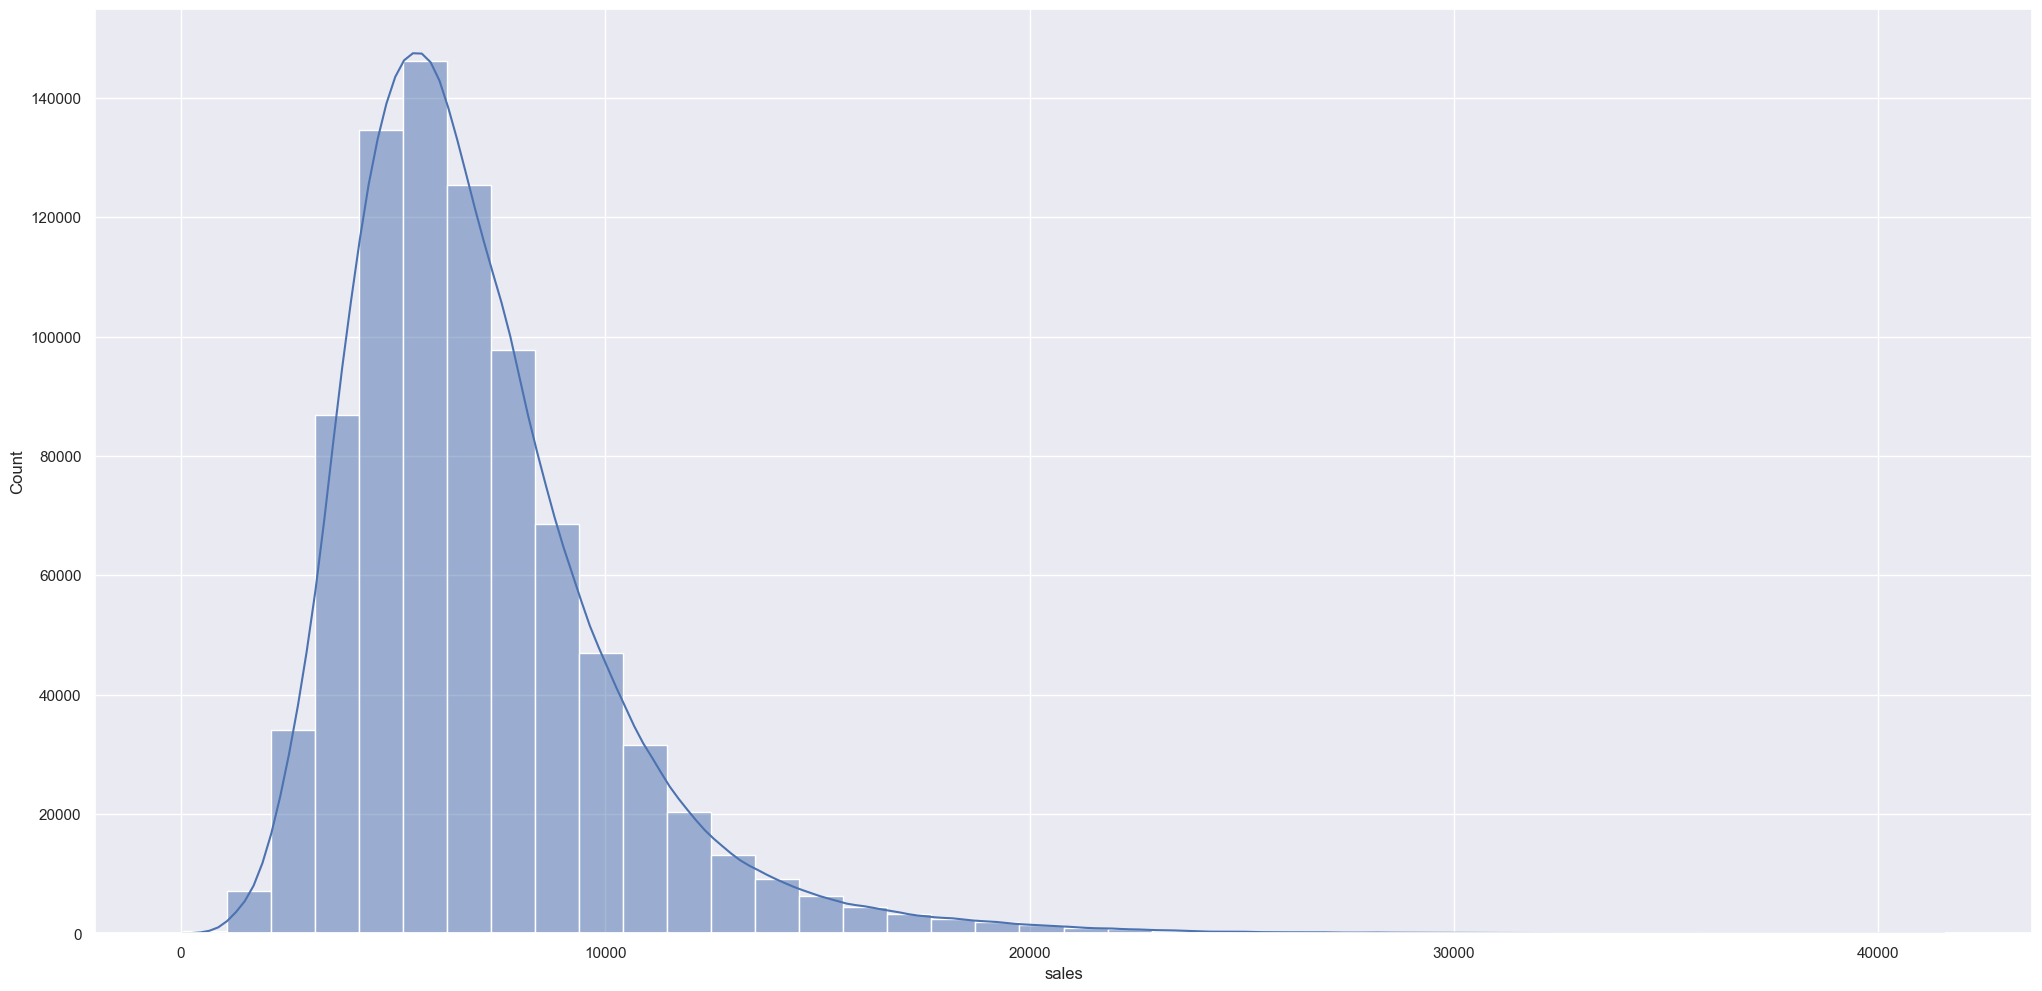

In [29]:
sns.histplot(df4['sales'], kde=True, bins=40 );

### 4.1.2 Numerical Variable

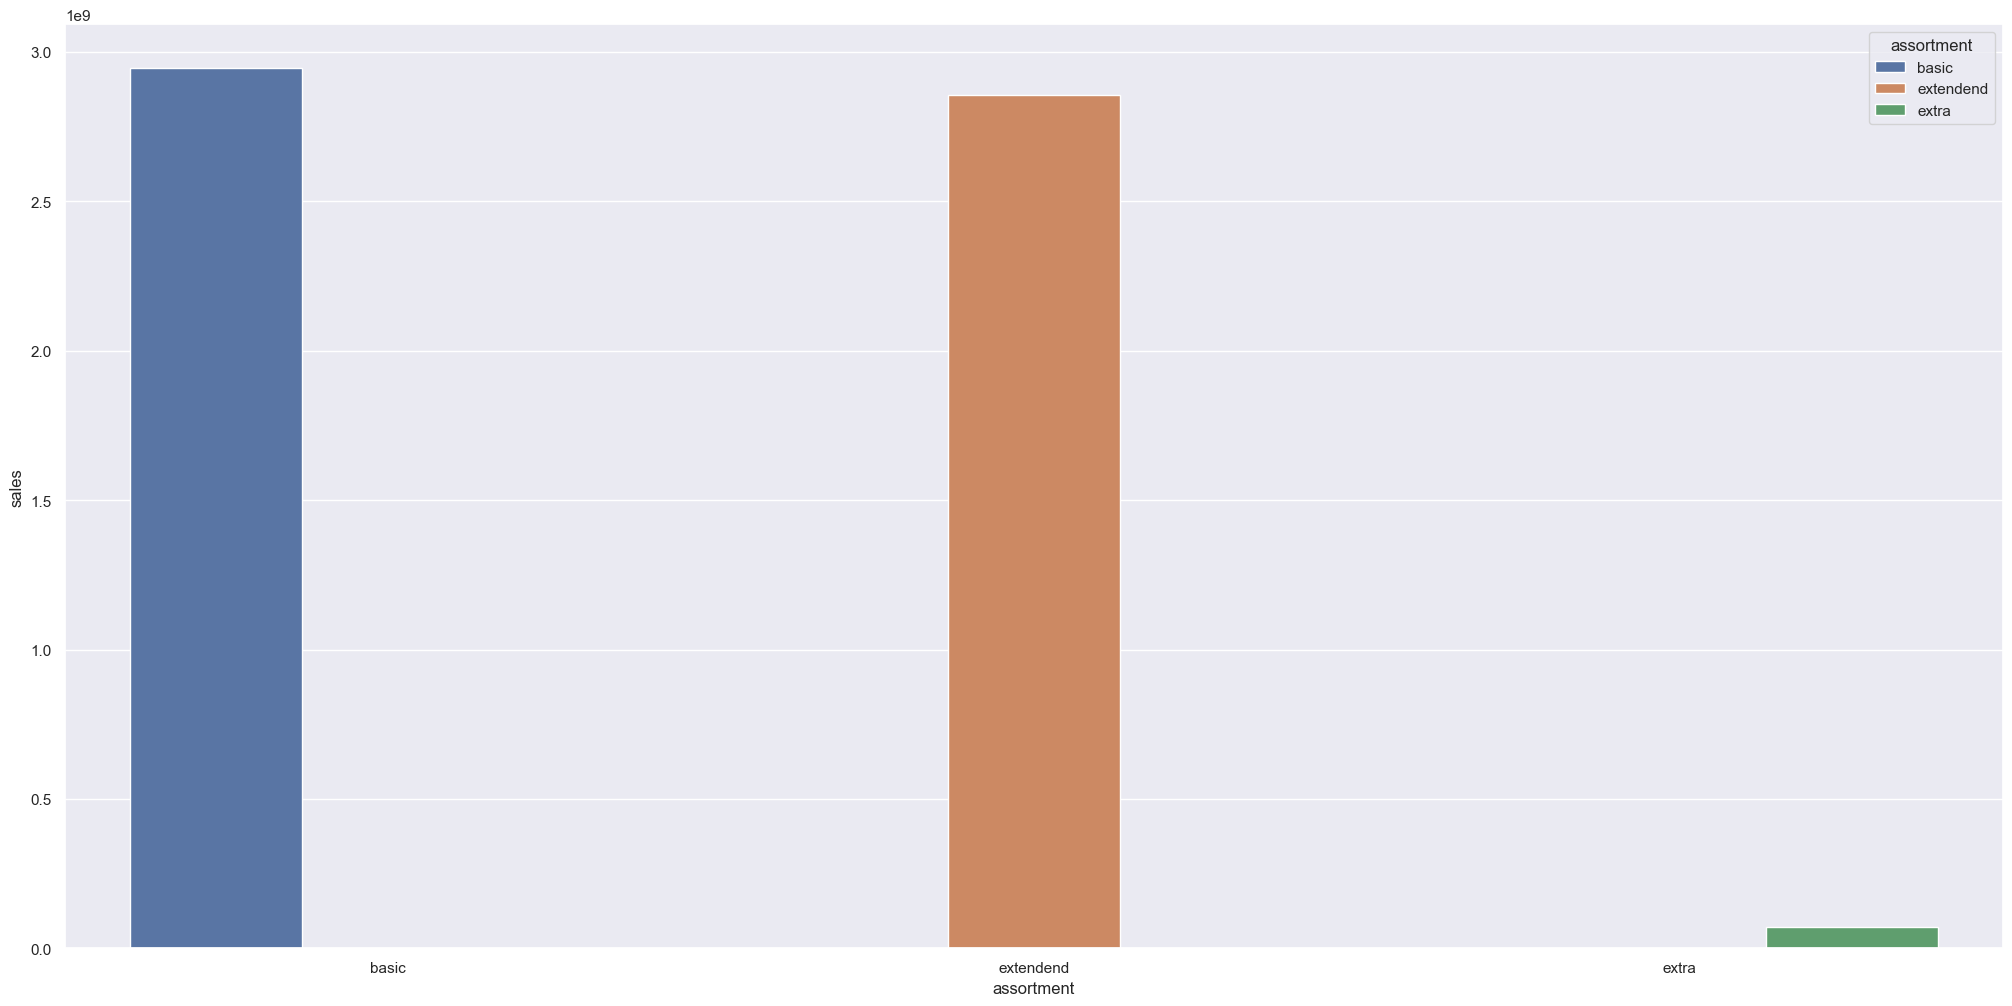

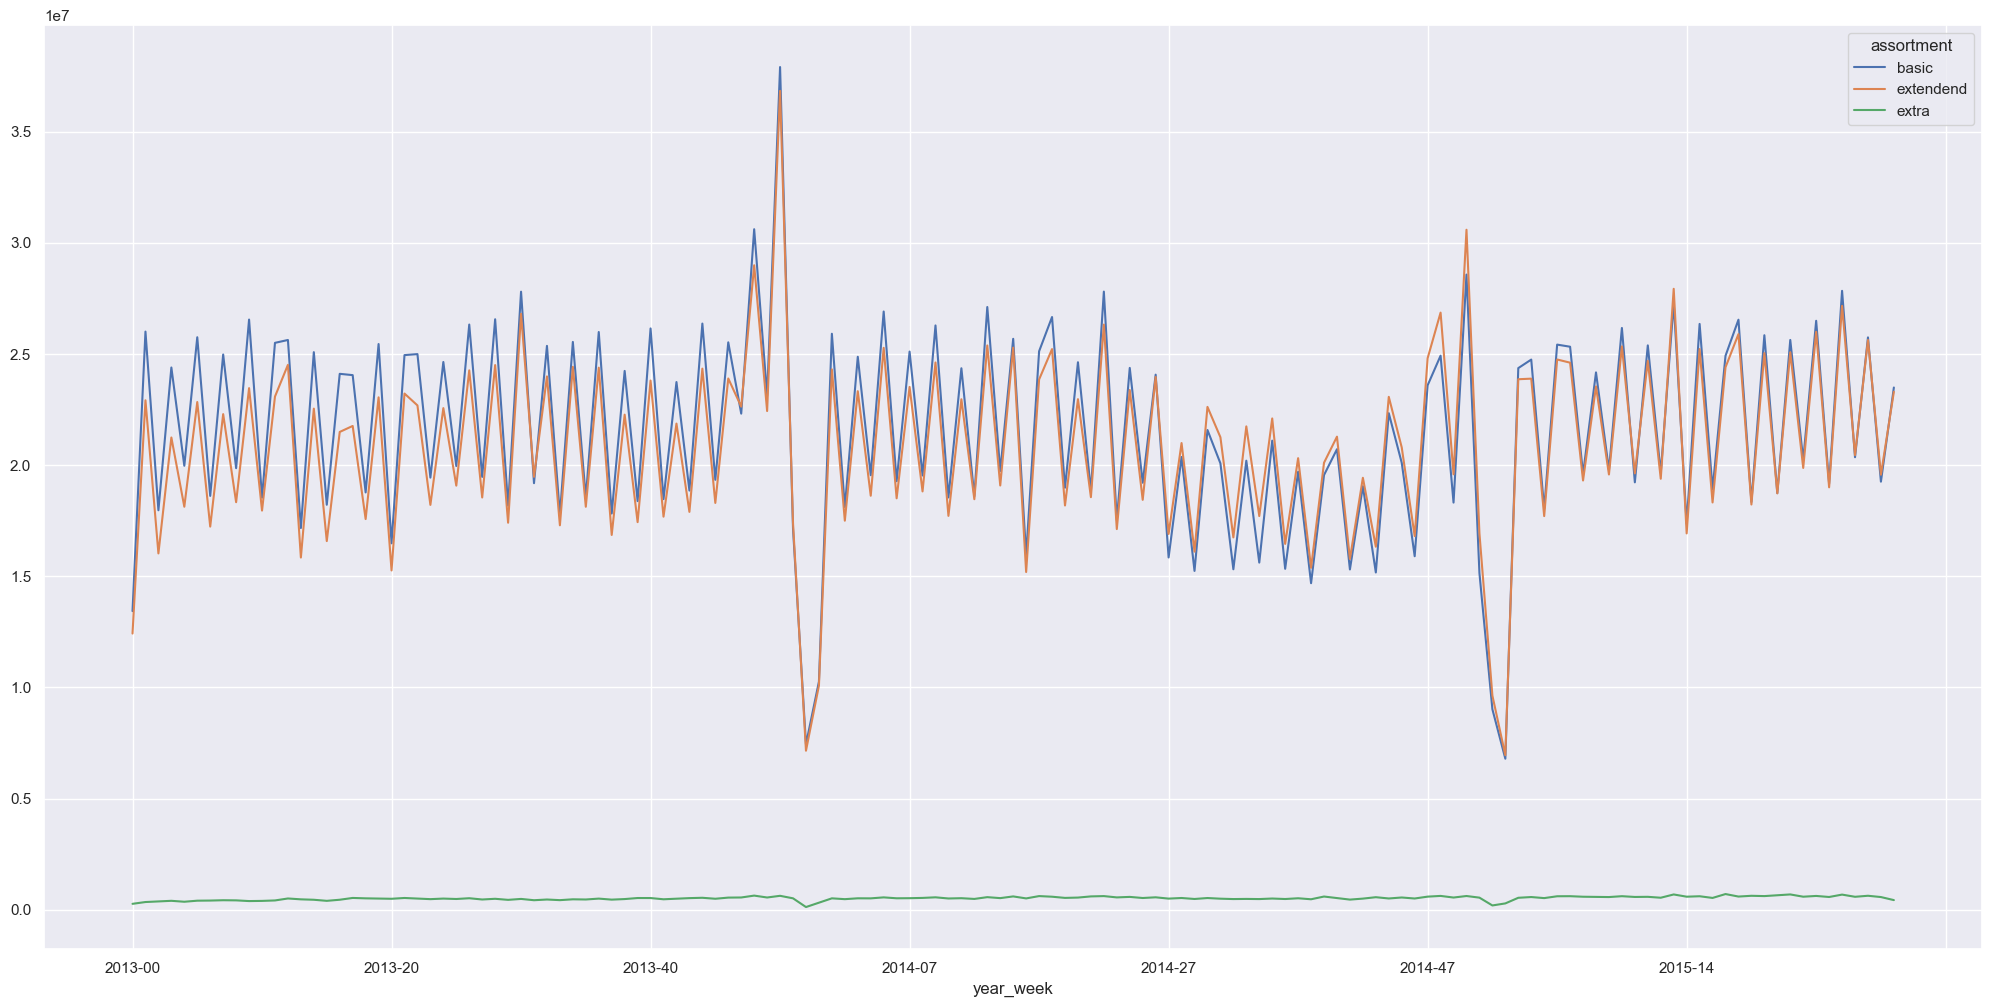

In [30]:
aux1 = df4[['assortment', 'sales']].groupby(['assortment']).sum().reset_index()
sns.barplot ( x='assortment', y='sales', data=aux1, hue='assortment' );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales'  ).plot();

### 4.1.3 Categorical Variable

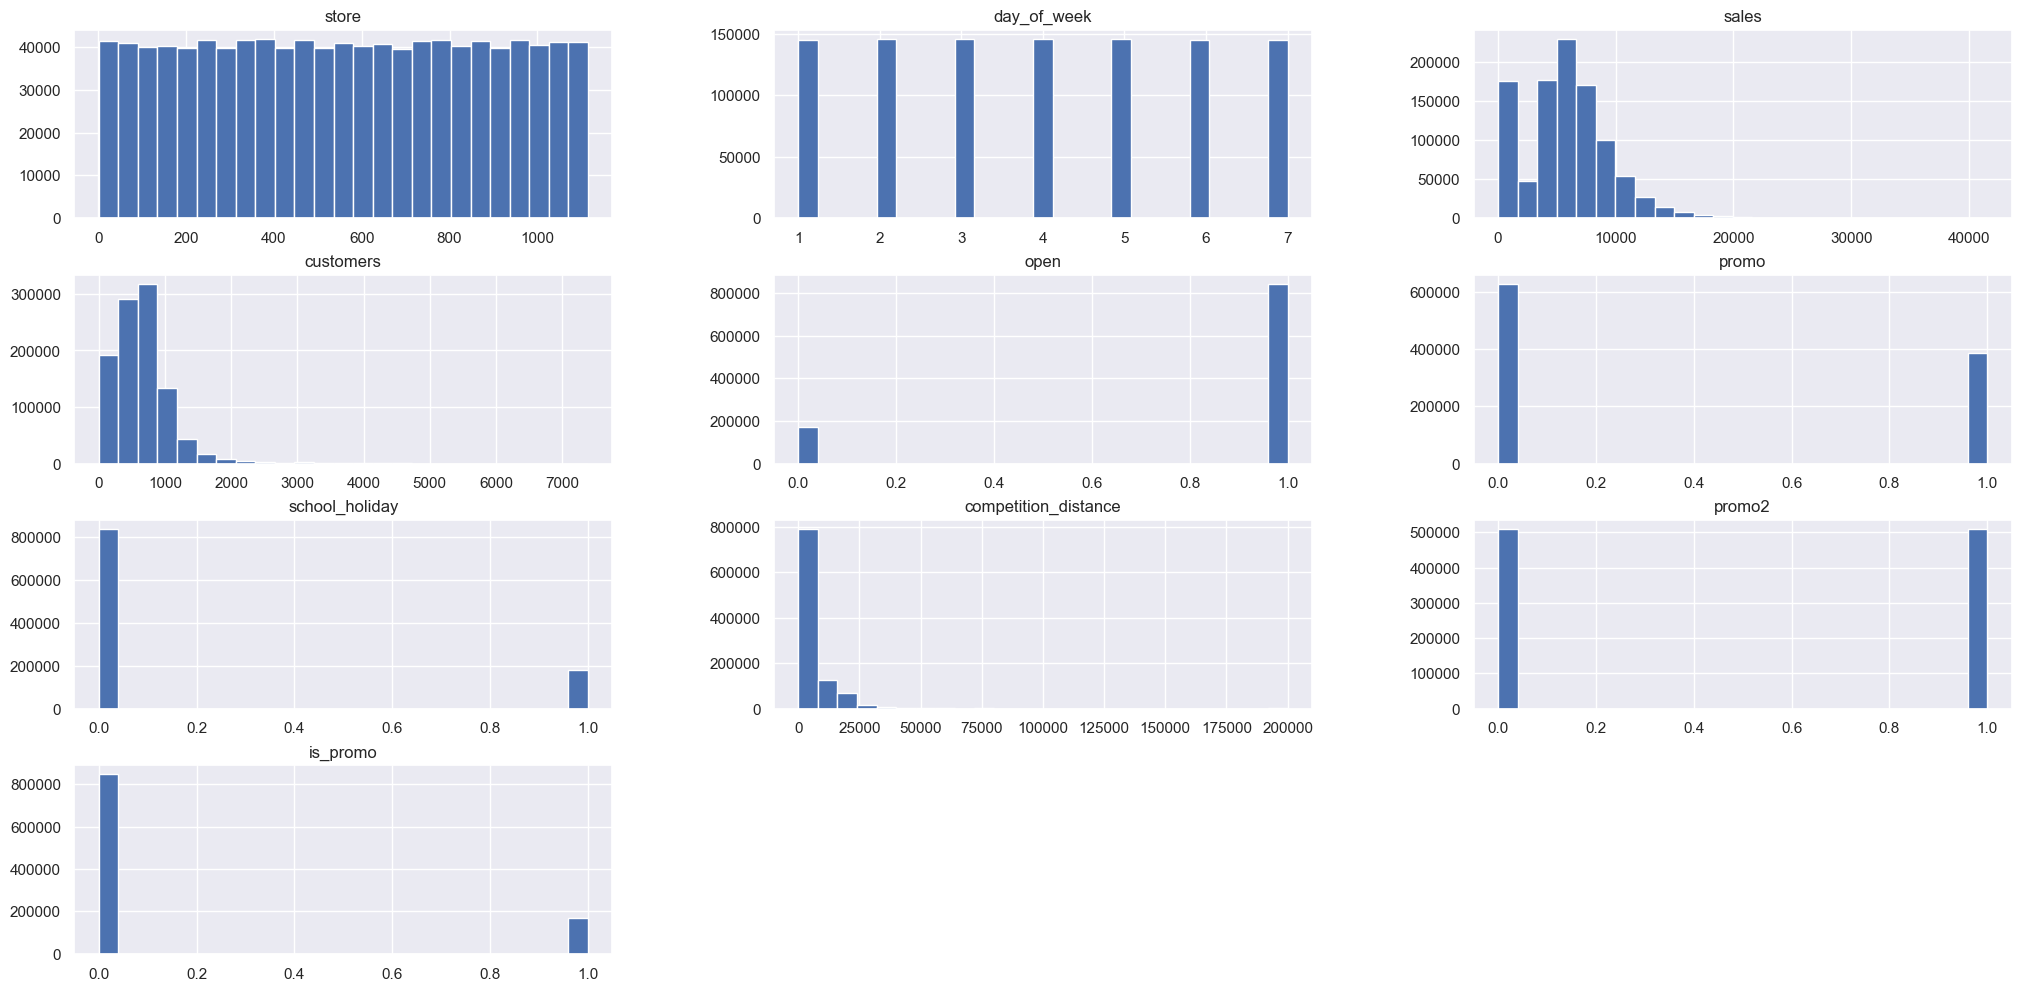

In [31]:
num_attributes.hist( bins=25 );

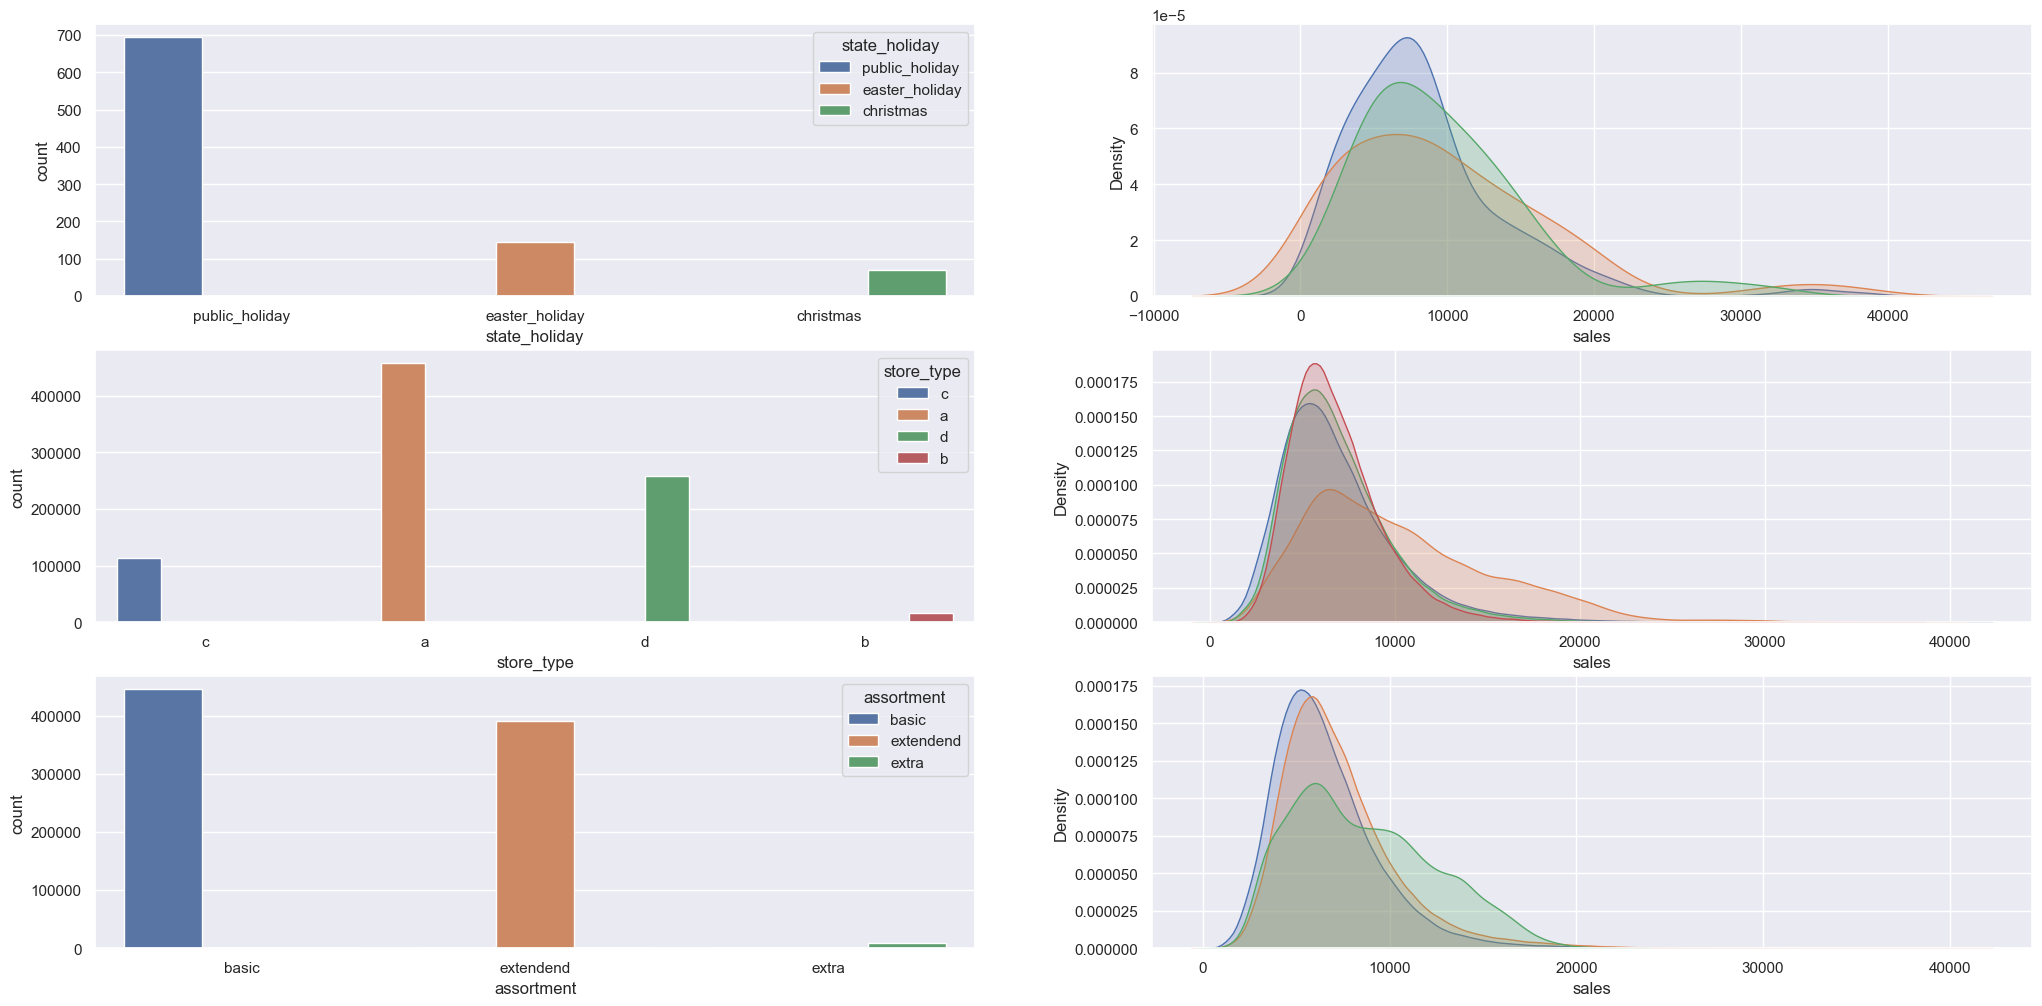

In [32]:
# state_holiday
plt.subplot ( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x='state_holiday', data=a, hue='state_holiday' );

plt.subplot ( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );

# store_type
plt.subplot ( 3, 2, 3)
sns.countplot( x='store_type', data=df4, hue='store_type' );

plt.subplot ( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True );

#assortment
plt.subplot ( 3, 2, 5)
sns.countplot( x='assortment', data=df4, hue='assortment' );

plt.subplot ( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extendend']['sales'], label='extendend', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True );



   ## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

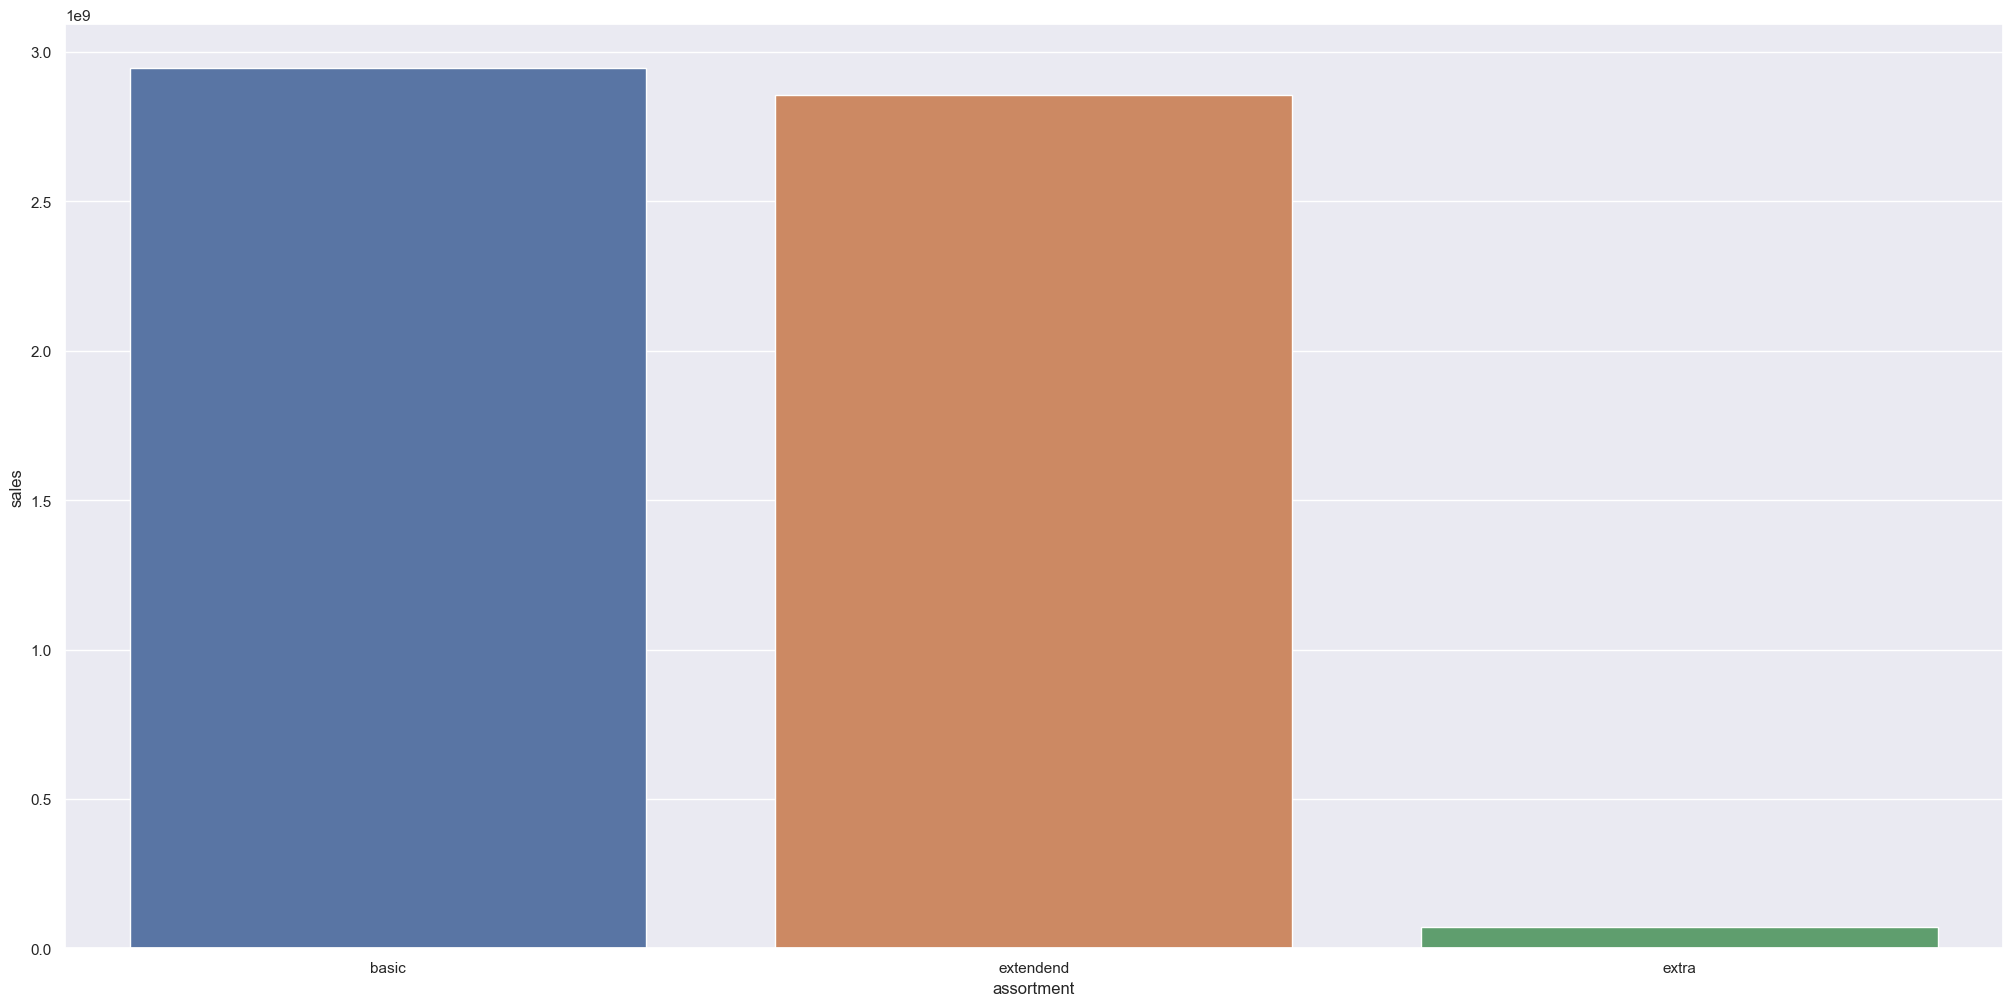

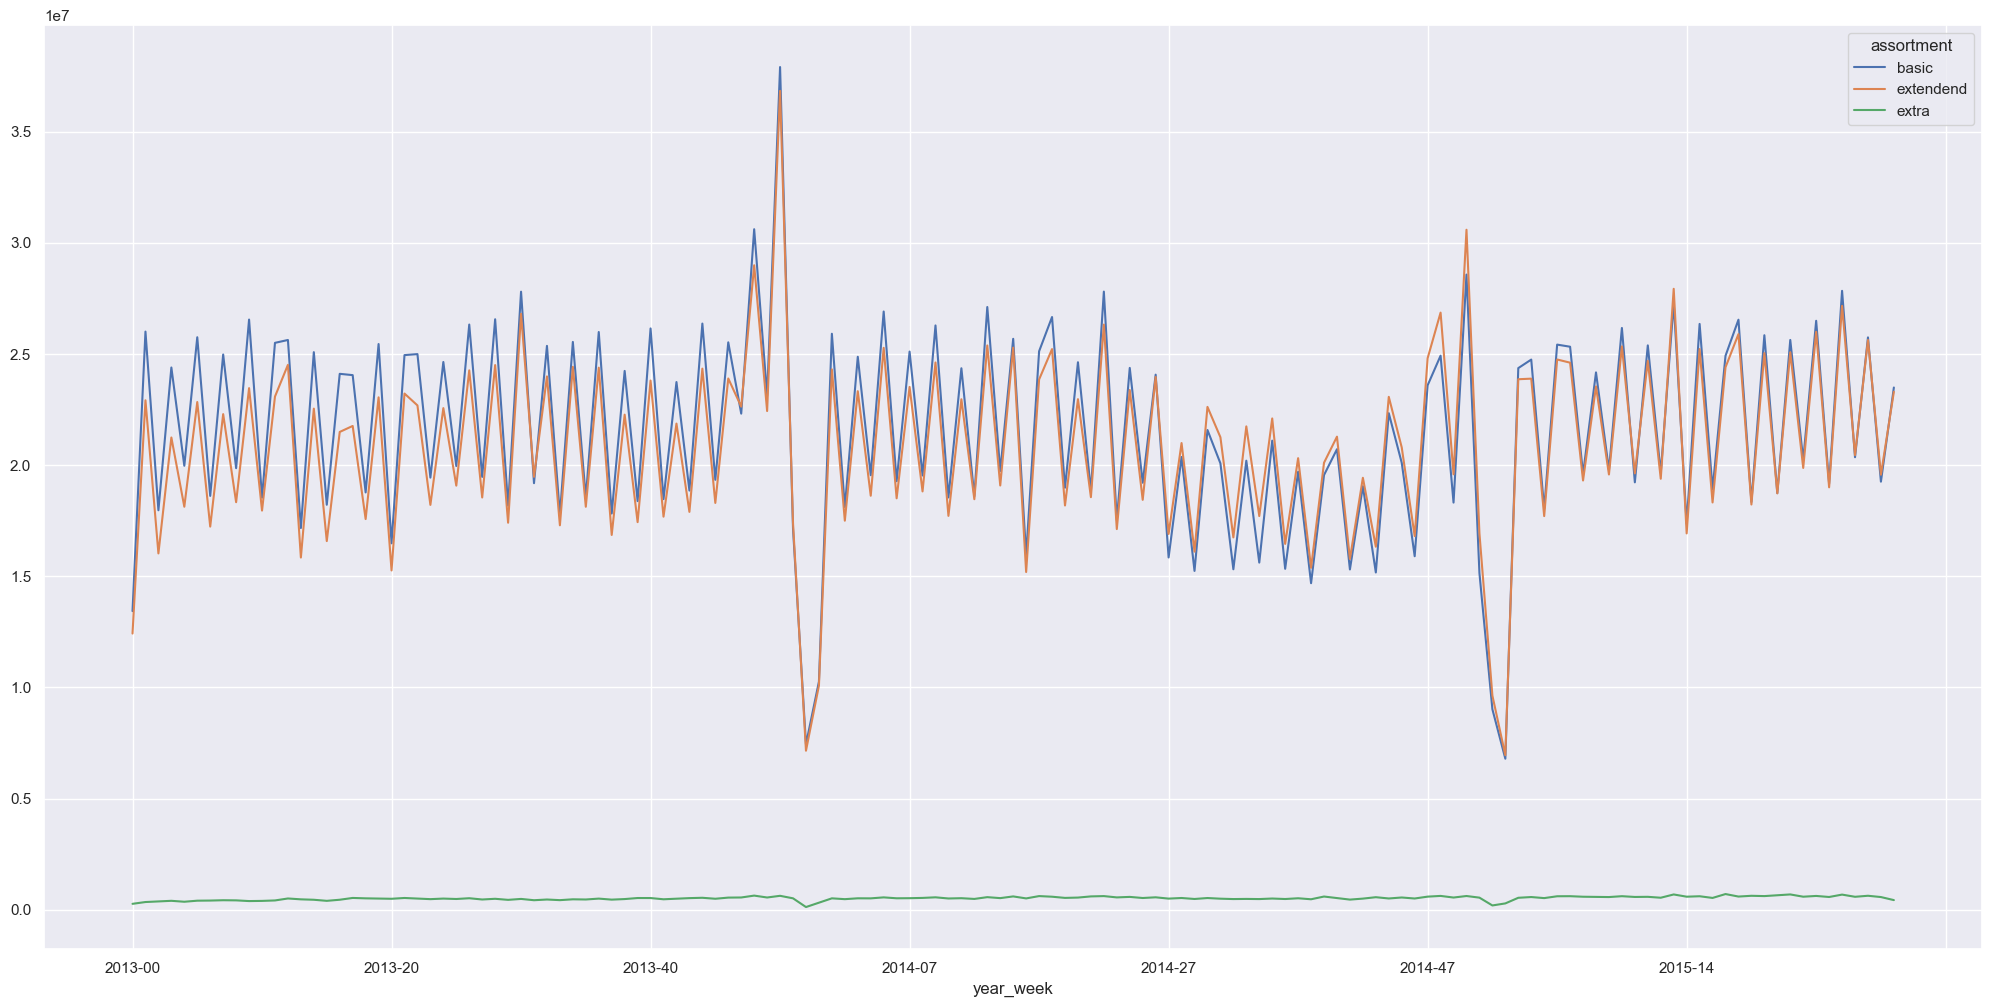

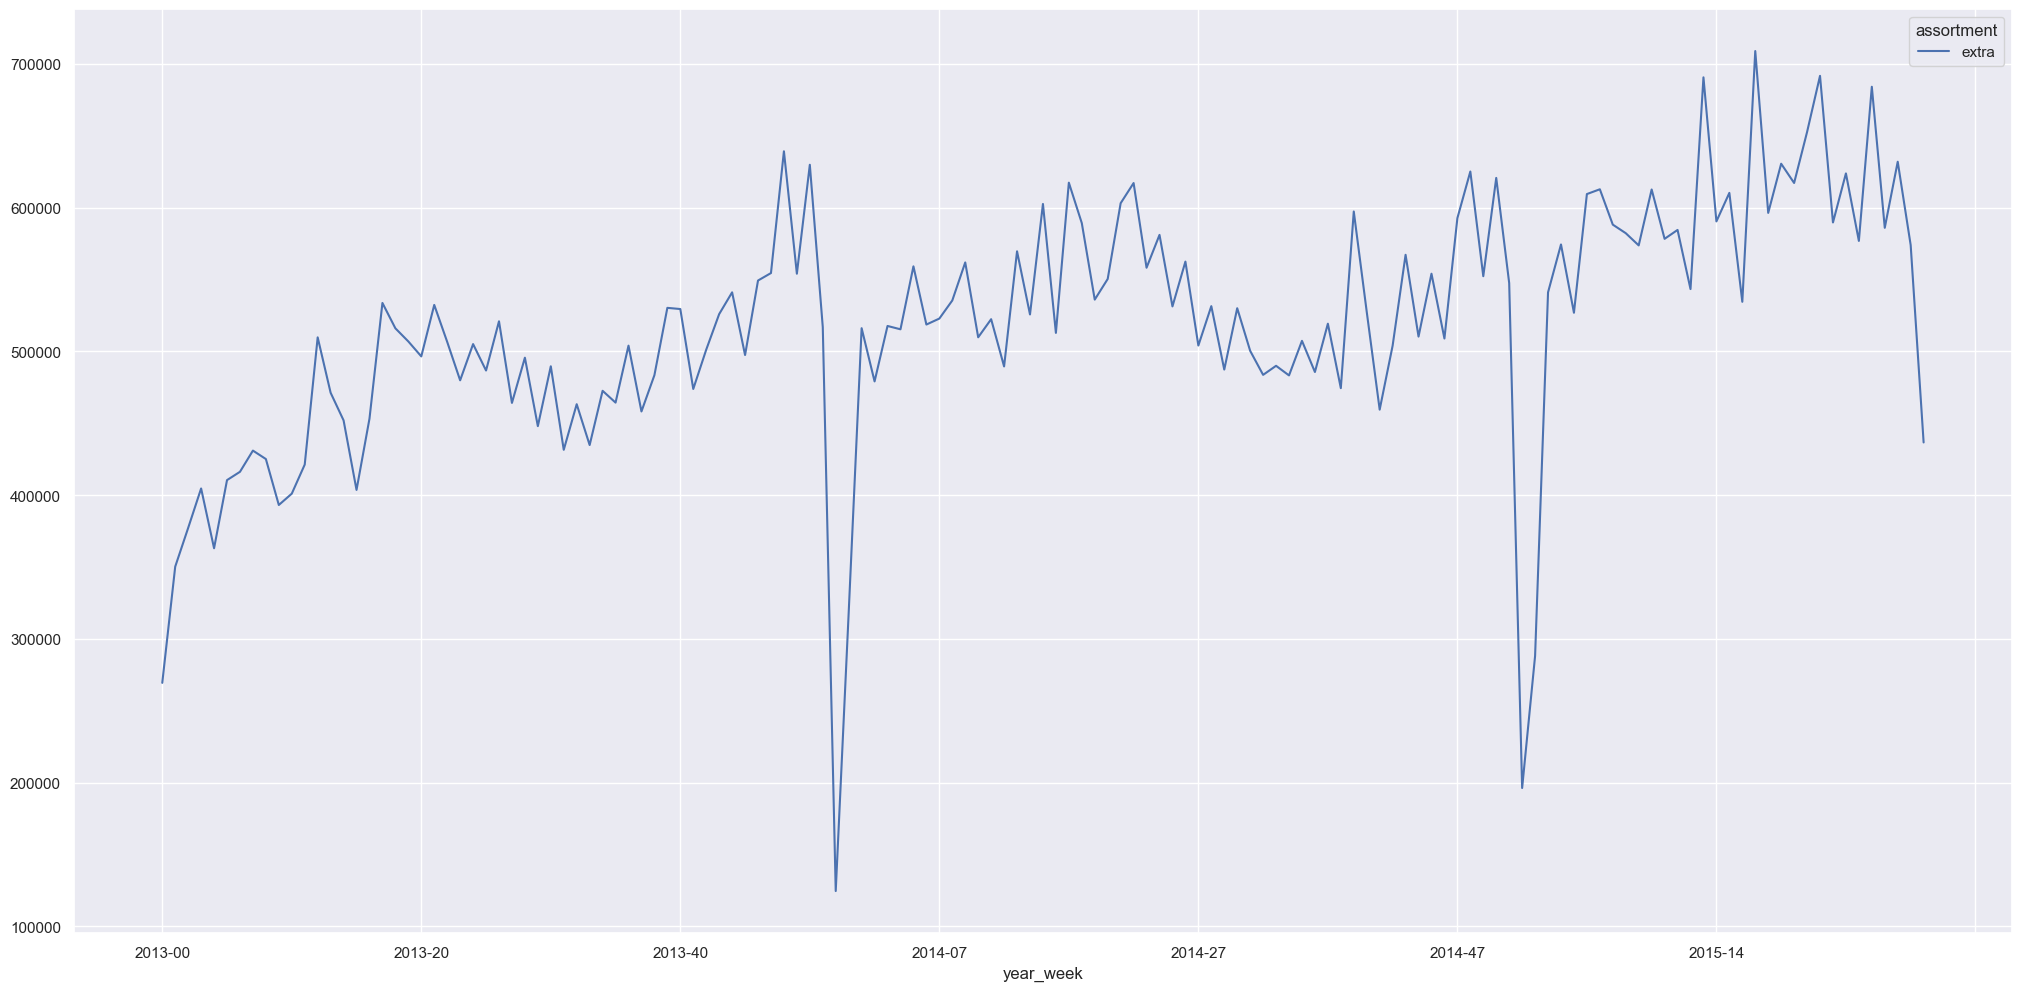

In [33]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();


aux3 = aux2[aux2['assortment'] =='extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos devereiam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais.

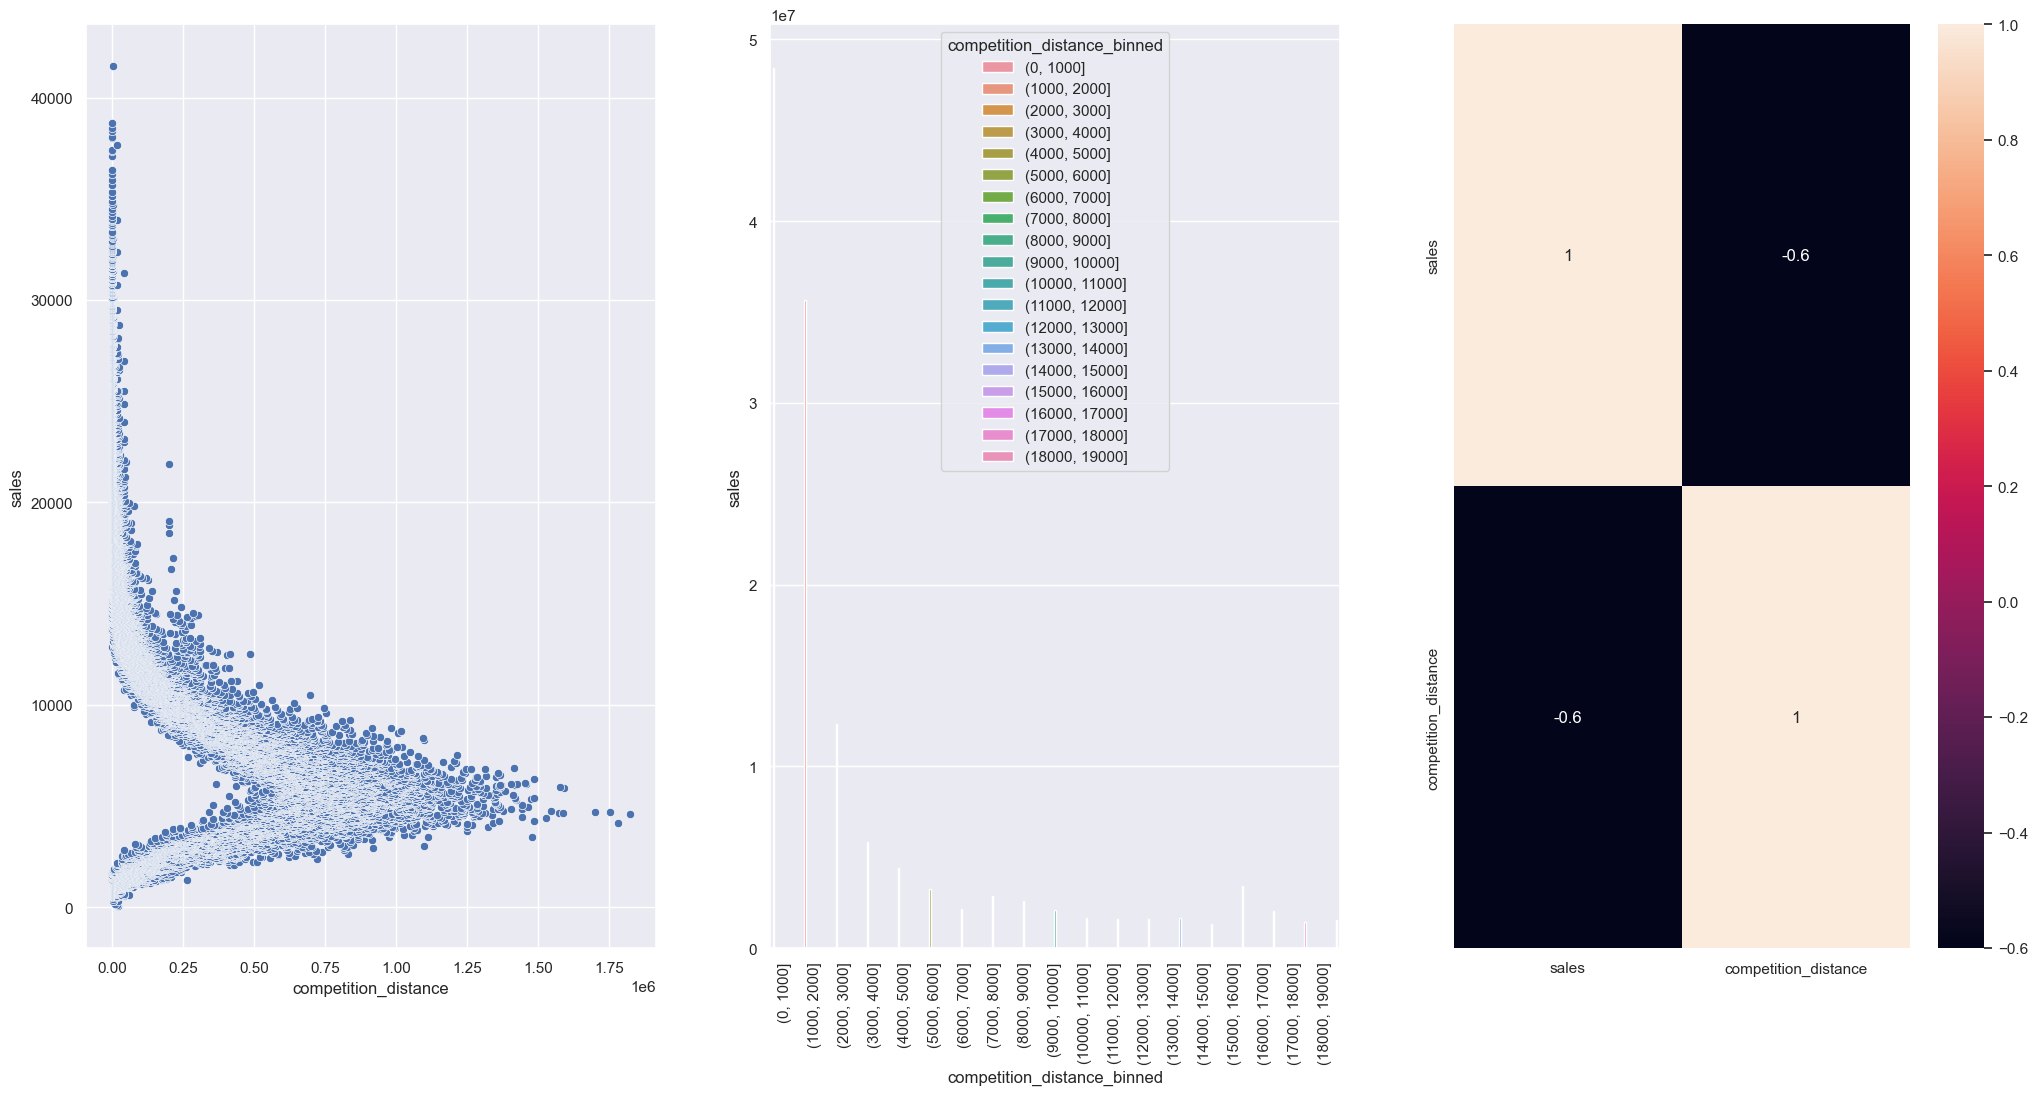

In [34]:
plt.subplot ( 1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot ( 1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( aux2, x='competition_distance_binned', y='sales', hue='competition_distance_binned' );
plt.xticks(rotation=90);

plt.subplot ( 1, 3, 3)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index().astype( int )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo devereiam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO VENDEM MENOS

C:\Users\Wilmara\AppData\Local\Temp\ipykernel_12492\2279366020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2['competition_time_month'] = pd.cut( aux2['competition_time_month'], bins=bins )


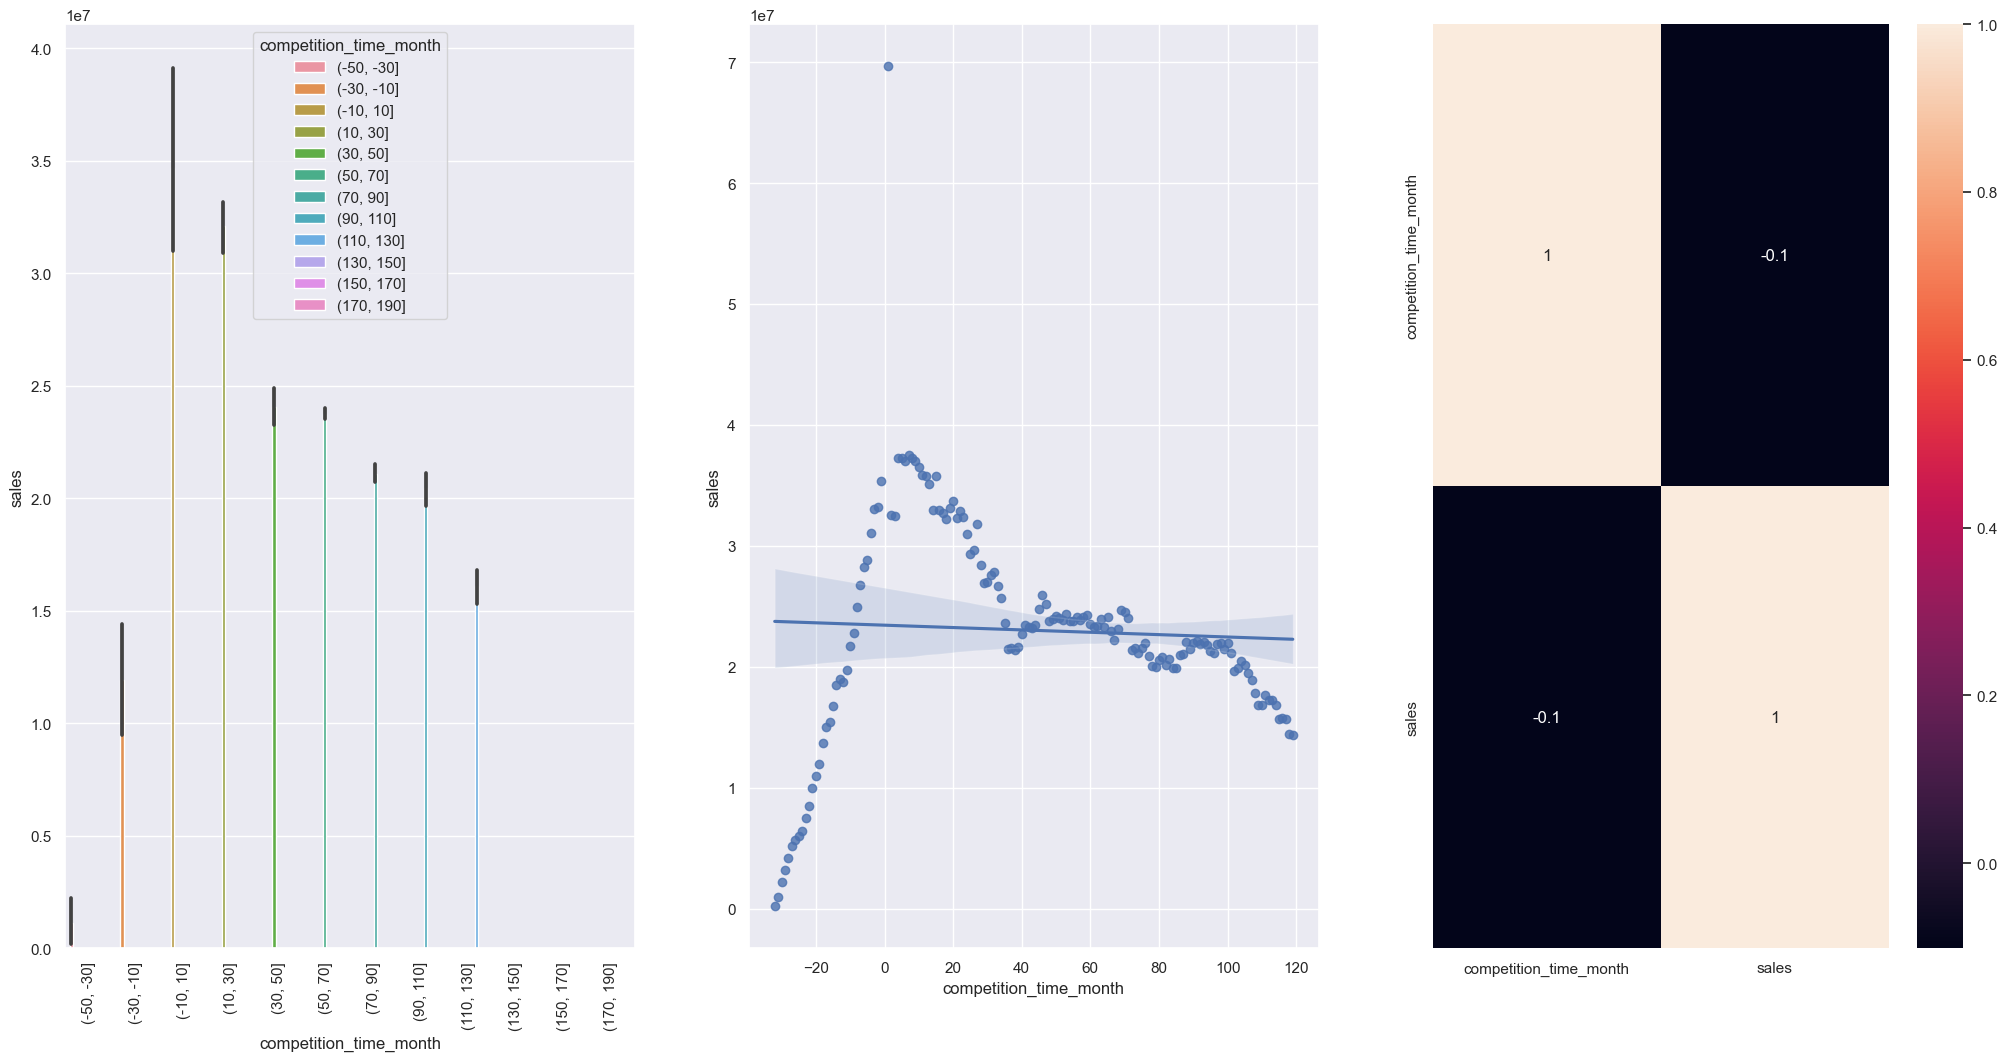

In [35]:
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
bins = list( np.arange( -50, 200, 20 ) )
aux2['competition_time_month'] = pd.cut( aux2['competition_time_month'], bins=bins )
sns.barplot( aux2, x='competition_time_month', y='sales', hue='competition_time_month' );
plt.xticks(rotation=90);

plt.subplot( 1, 3, 2 )
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
sns.regplot( aux2, x='competition_time_month', y='sales' );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA***. Lojas com promoções ativas vendem menos após certo período de promoção.

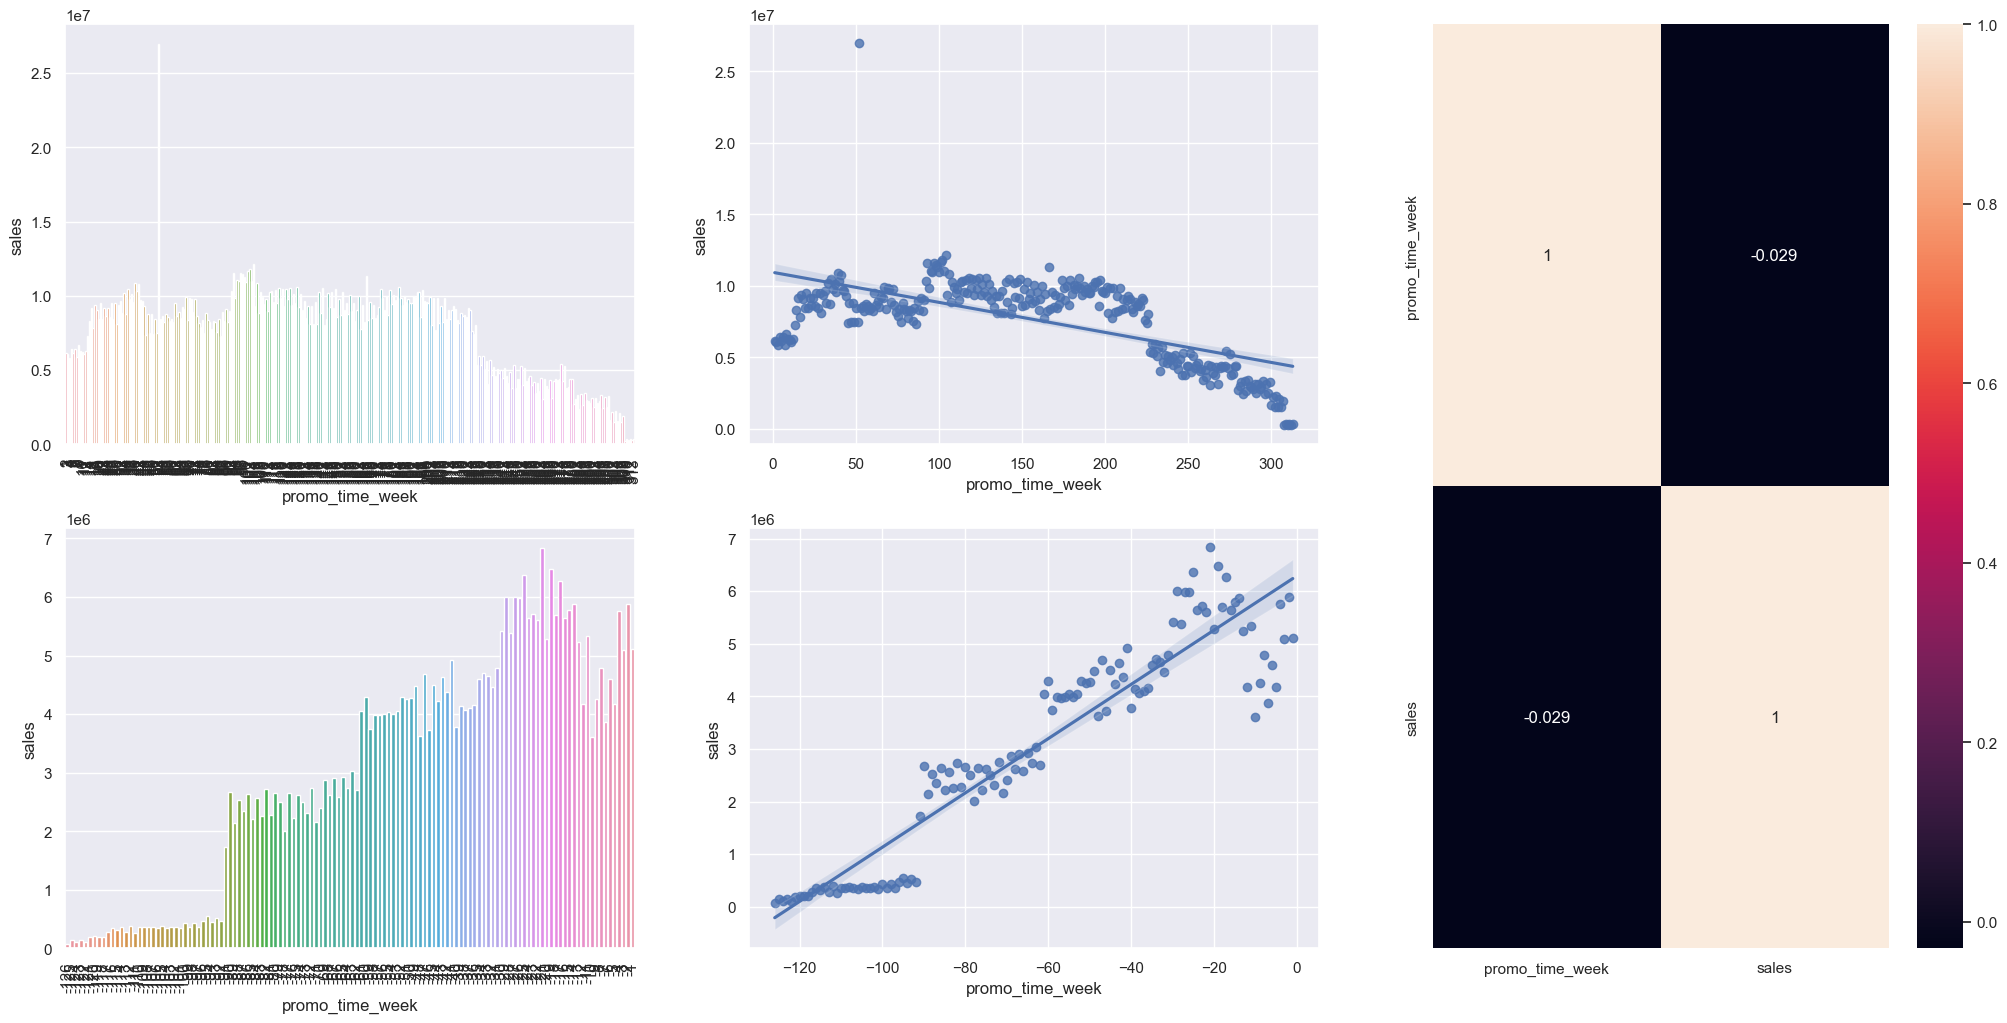

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot( data=aux2, x='promo_time_week', y='sales' );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( data=aux2, x='promo_time_week', y='sales' );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( data=aux3, x='promo_time_week', y='sales' );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( data=aux3, x='promo_time_week', y='sales' );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções censecutivas deveriam vender mais.
***FALSA*** Lojas com mais promoções consecutivas vendem menos.

In [37]:
aux1 = df4[[ 'promo', 'promo2', 'sales' ]].groupby(['promo', 'promo2'] ).sum().reset_index().sort_values(by='sales', ascending=True)
#sns.barplot( data=aux1, x=('promo', 'promo2'), y='sales' );
aux1

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


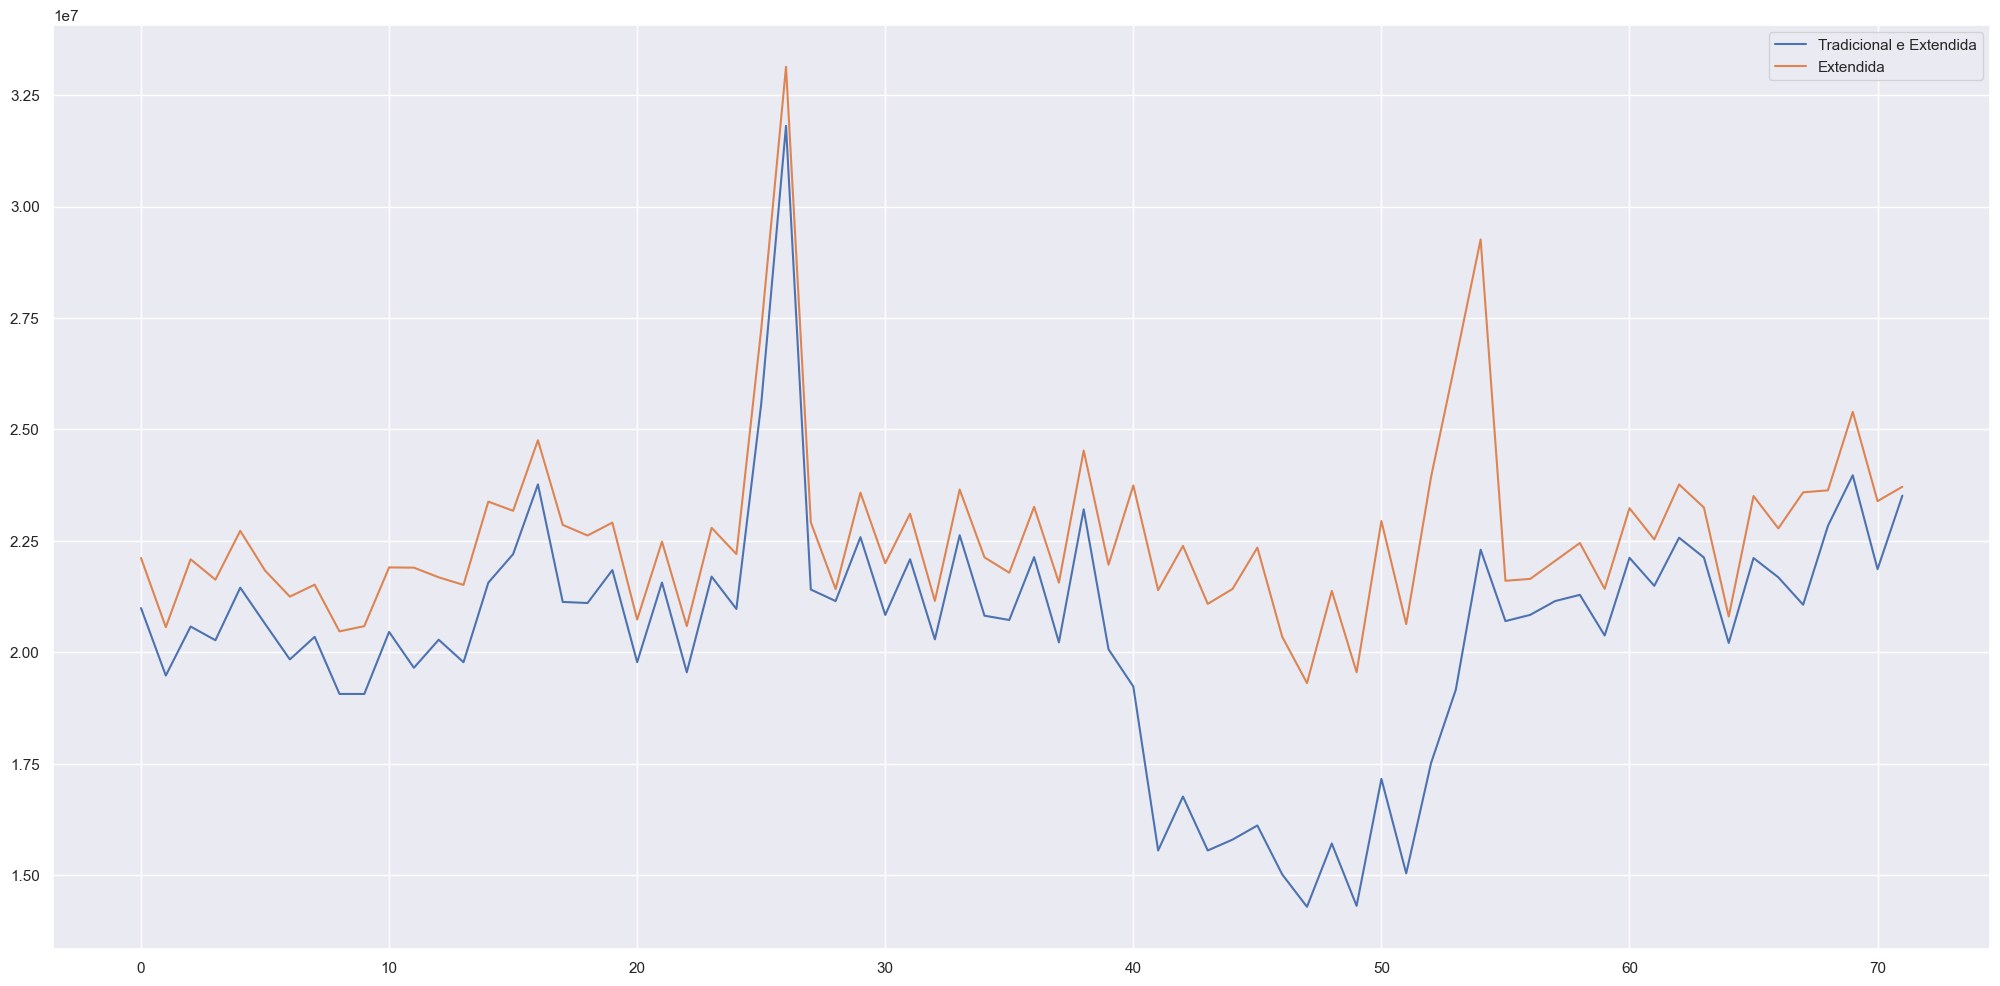

In [38]:
aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional e Extendida', 'Extendida'] );

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
***FALSA*** As lojas vendem MAIS nos demais Feriados.

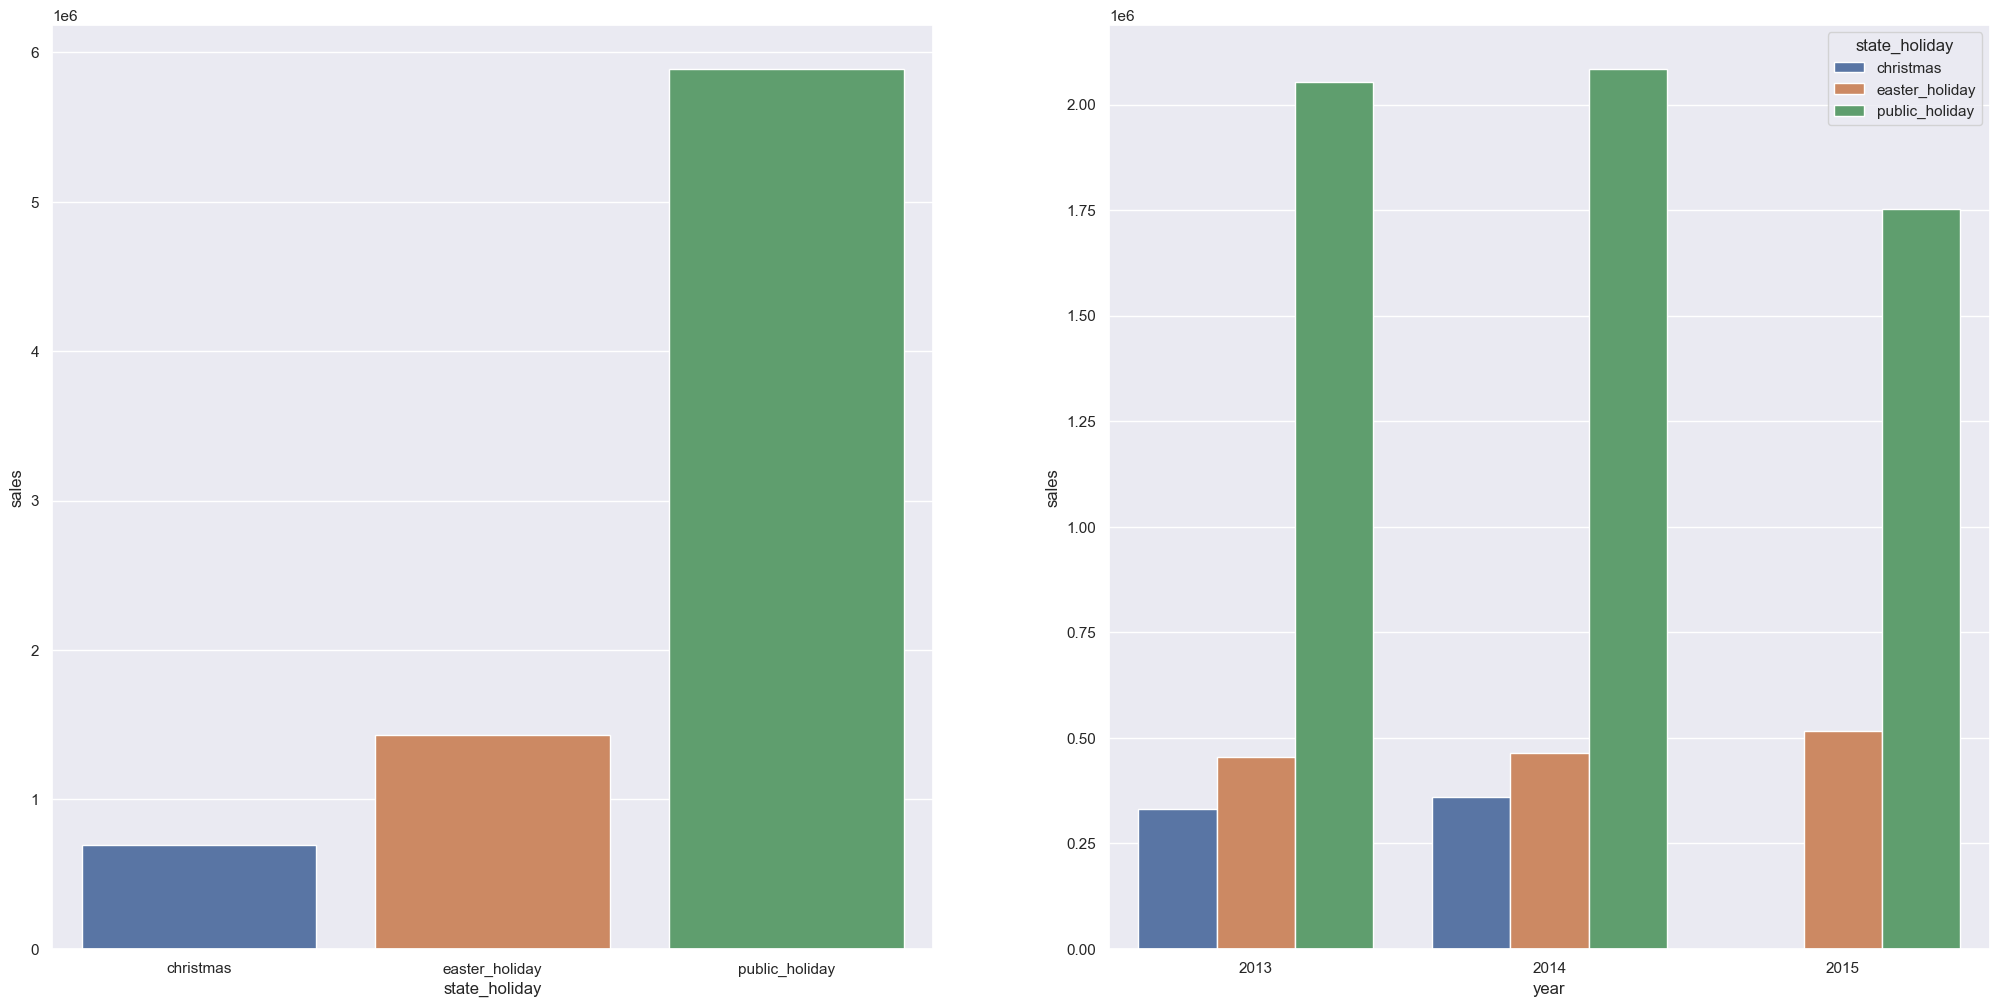

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot ( 1, 2, 1 )
sns.barplot( data=aux1, x='state_holiday', y='sales' );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot ( 1, 2, 2 )
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday' );

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
***FALSA*** Lojas vendem menos ao longo dos anos.

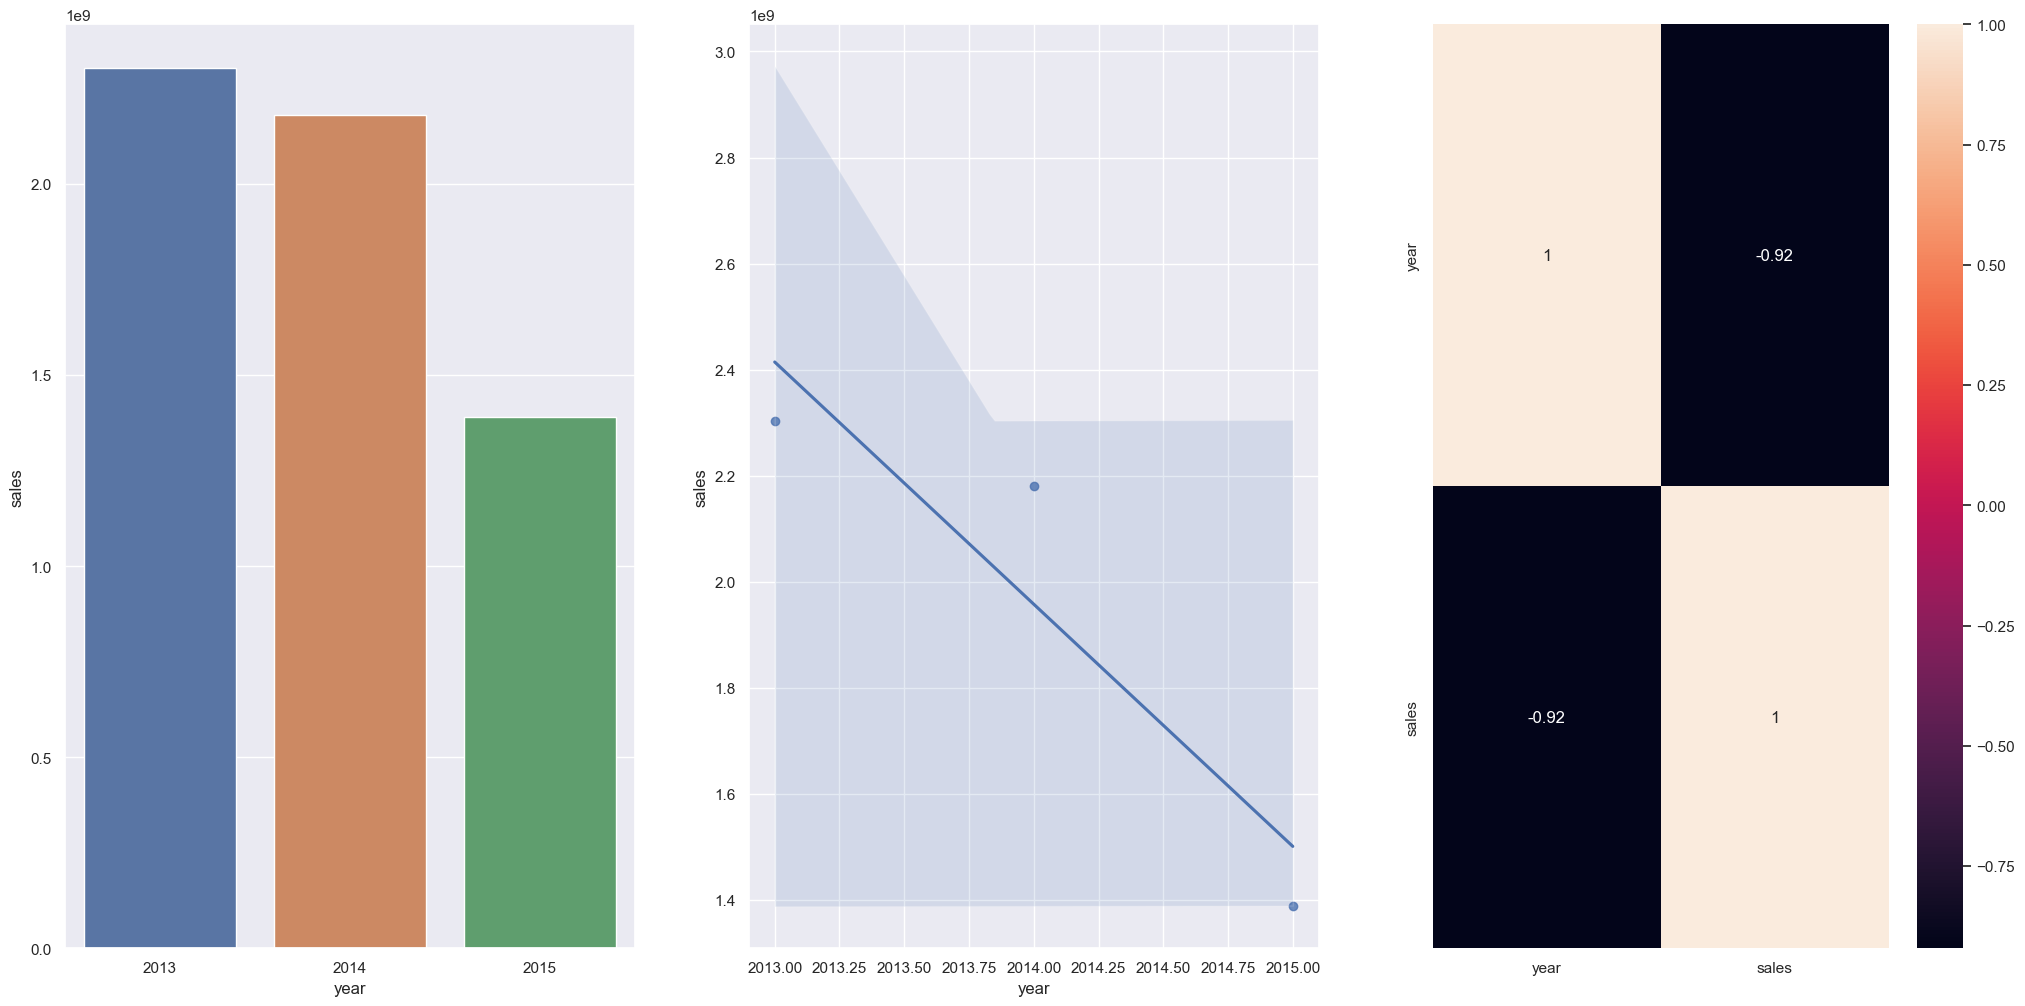

In [40]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='year', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='year', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
***FALSA*** As lojas vendem mais no primeiro semestre.



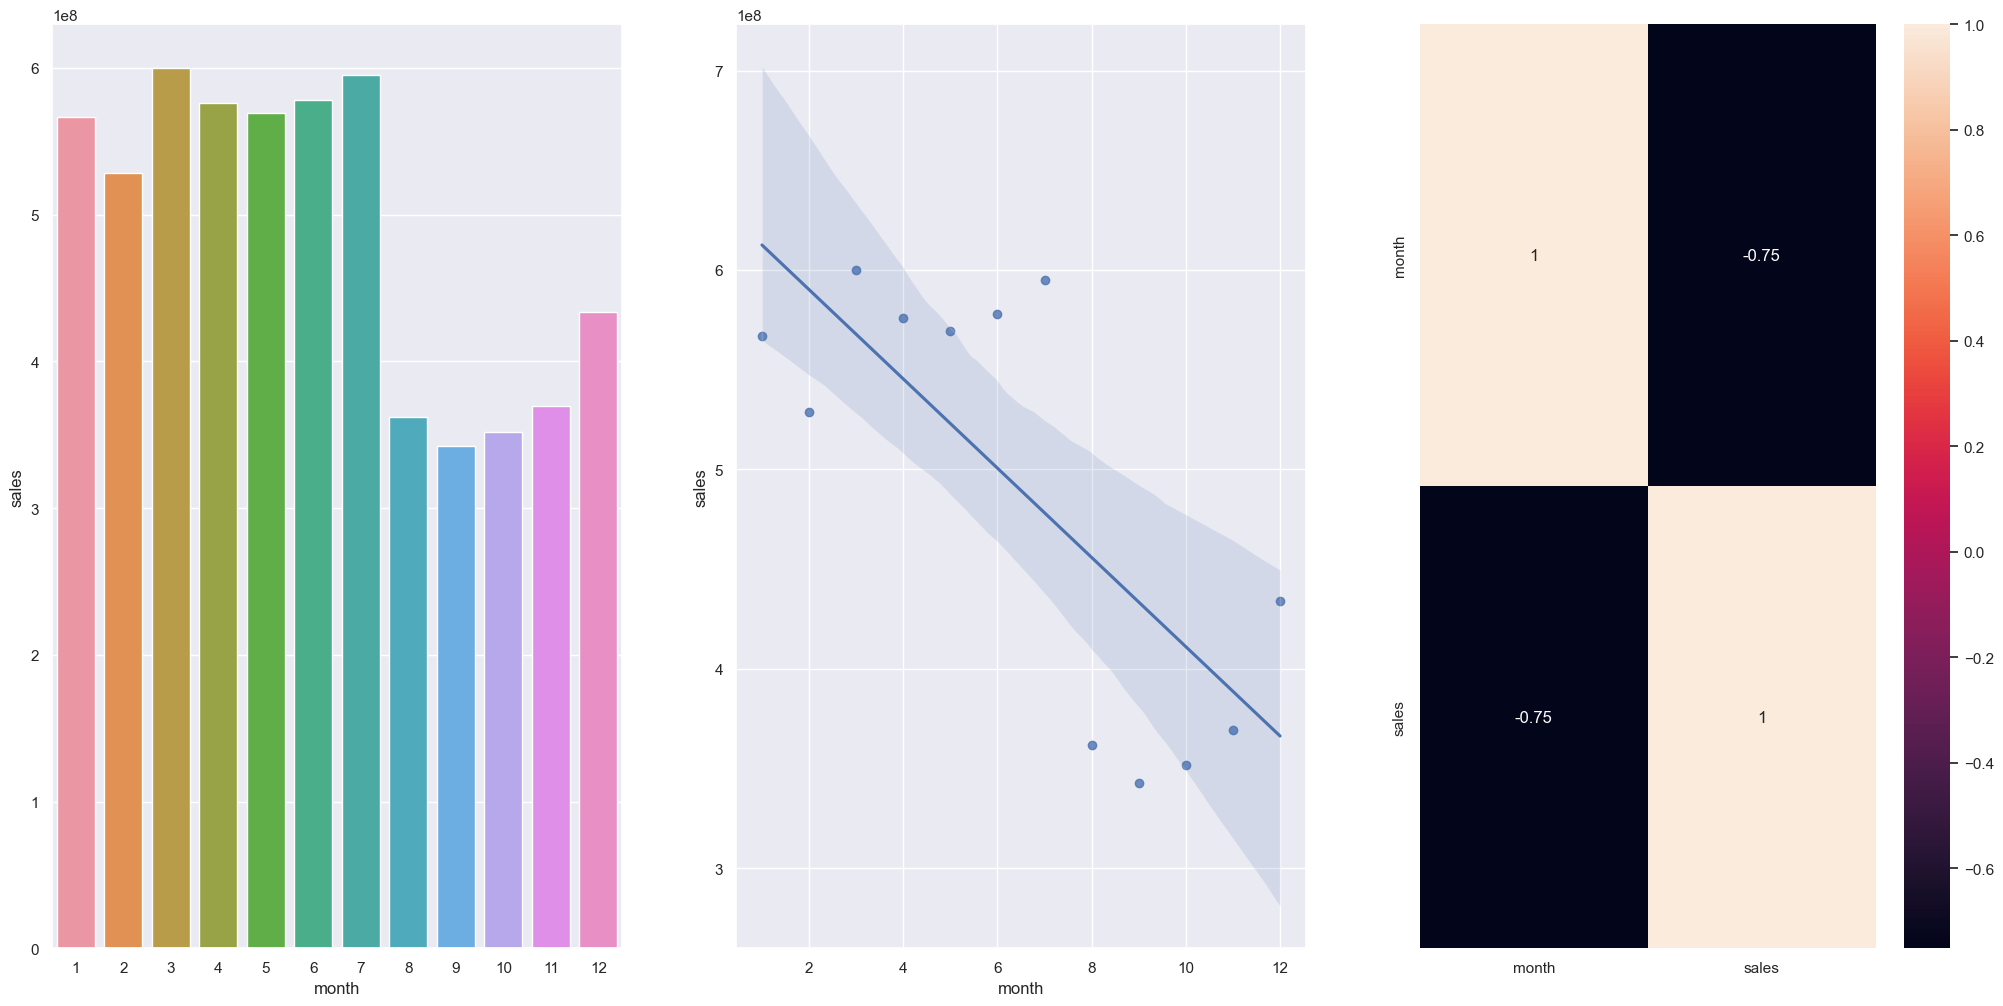

In [41]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='month', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='month', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA*** Lojas vendem menos até o dia 10.


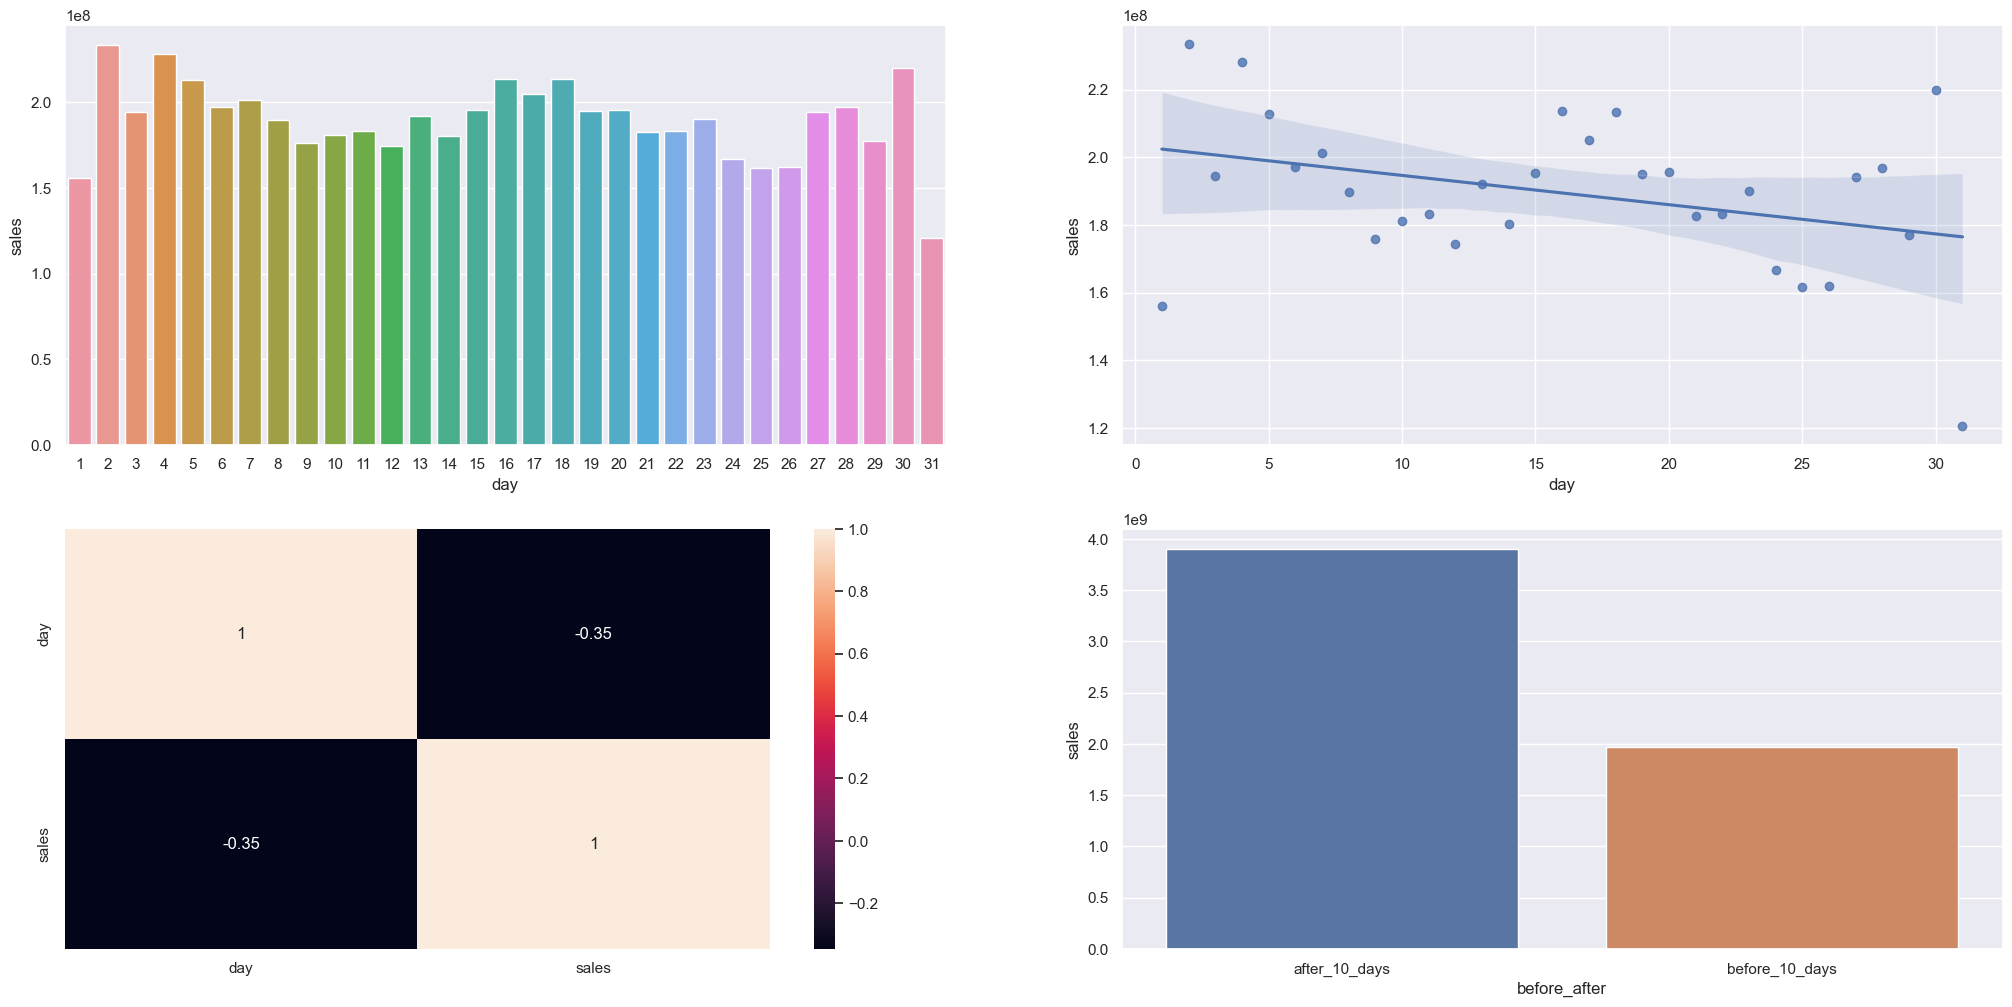

In [42]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot( 2, 2, 1)
sns.barplot( data=aux1, x='day', y='sales' );

plt.subplot( 2, 2, 2)
sns.regplot( data=aux1, x='day', y='sales' );

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot ( data=aux2, x='before_after', y='sales' );

### **H10.** Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA*** Lojas vendem mais nos dias regulares.



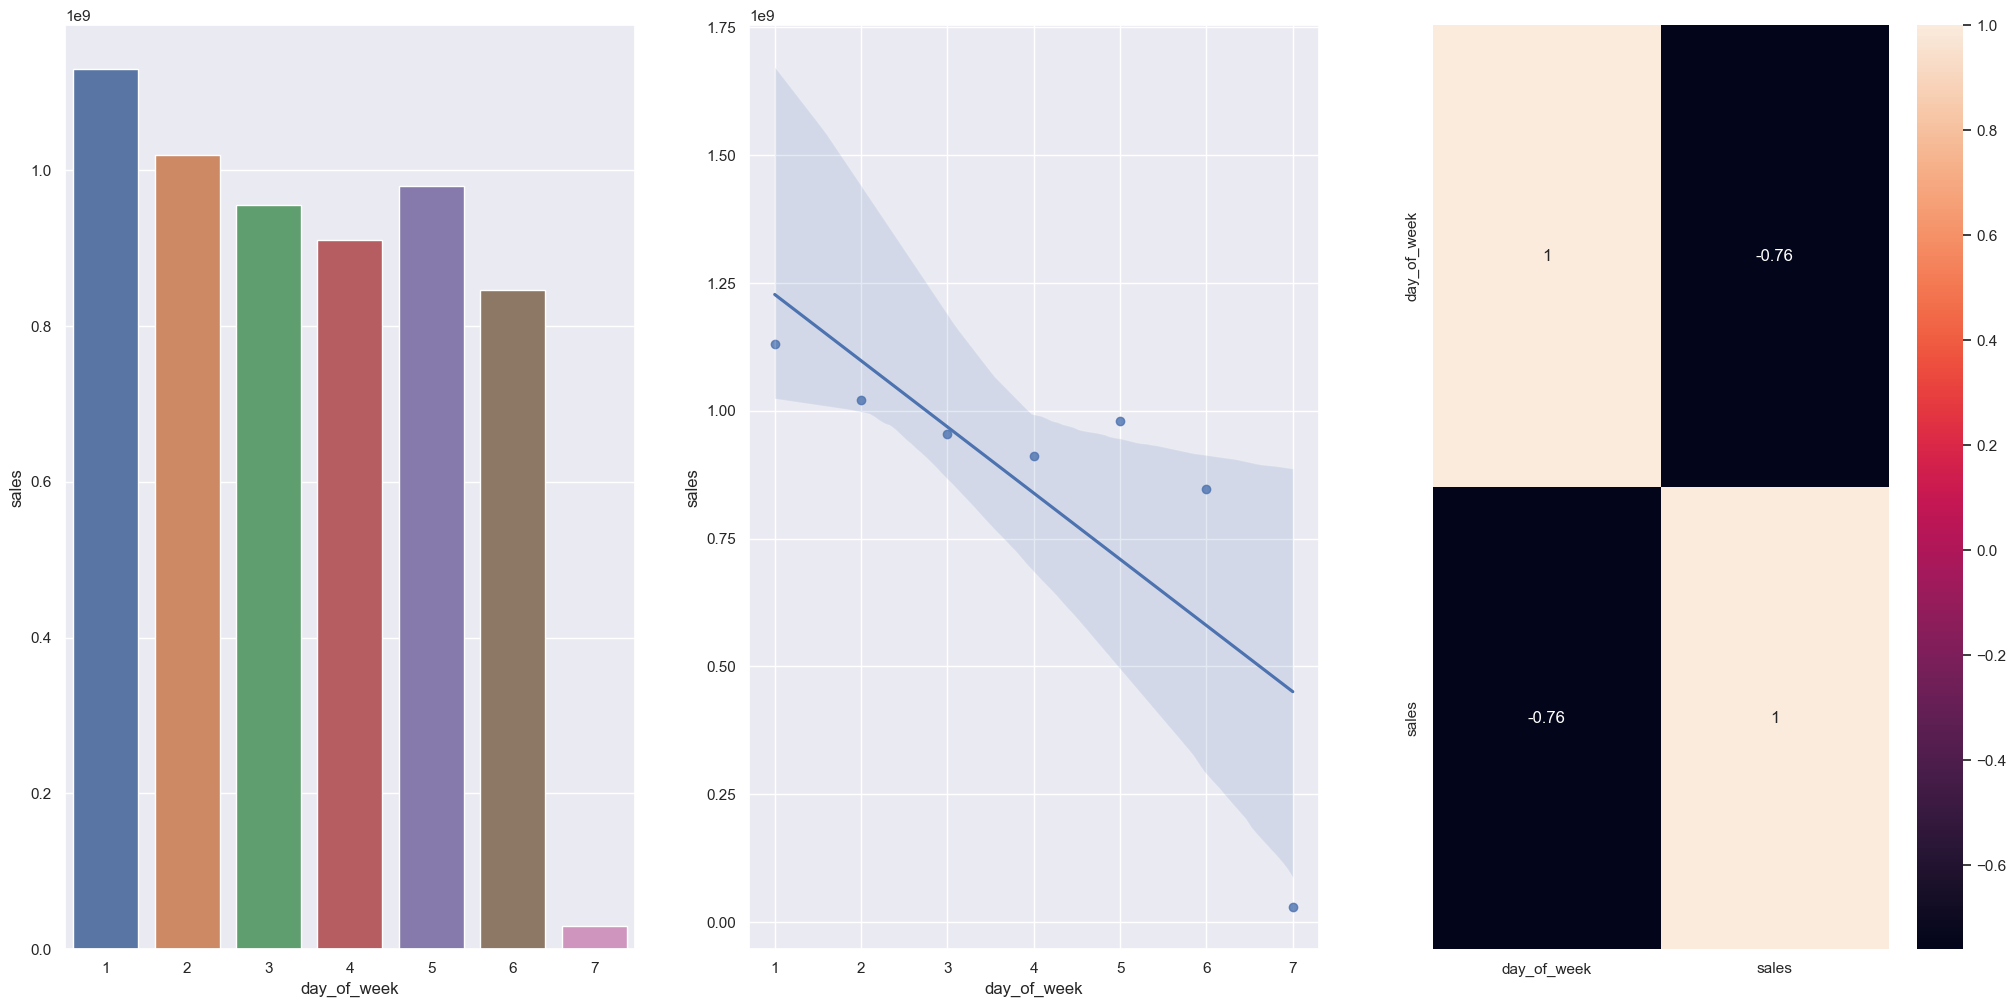

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='day_of_week', y='sales' );

plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='day_of_week', y='sales' );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA*** Lojas vendem menos nos feriados escolares.

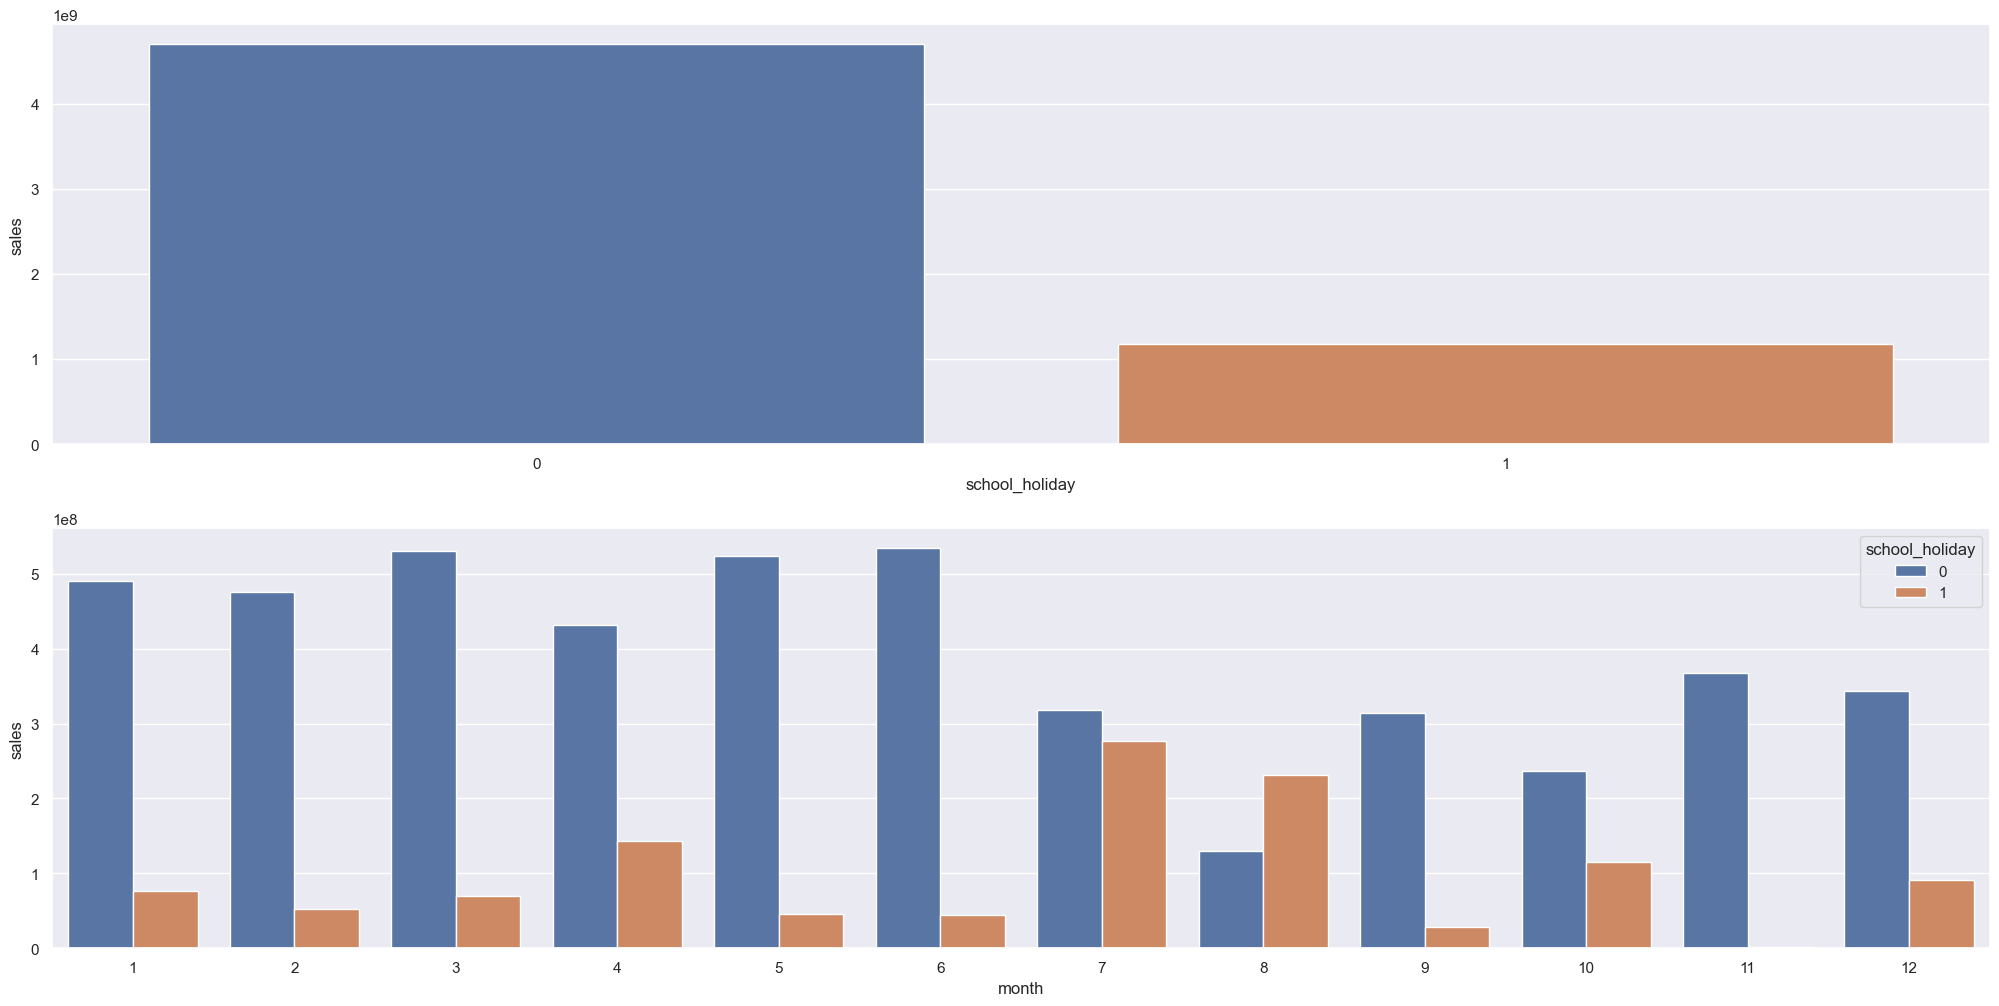

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot( 2, 1, 1)
sns.barplot( data=aux1, x='school_holiday', y='sales' );

aux2 = df4[[ 'month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2)
sns.barplot( data=aux2, x='month', y='sales', hue='school_holiday' );

### 4.2.1 Resumo das hipóteses

In [49]:
tab= [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Media'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Baixa']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Media
H10          Verdadeira   Alta
H11          Verdadeira   Baixa


  ## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

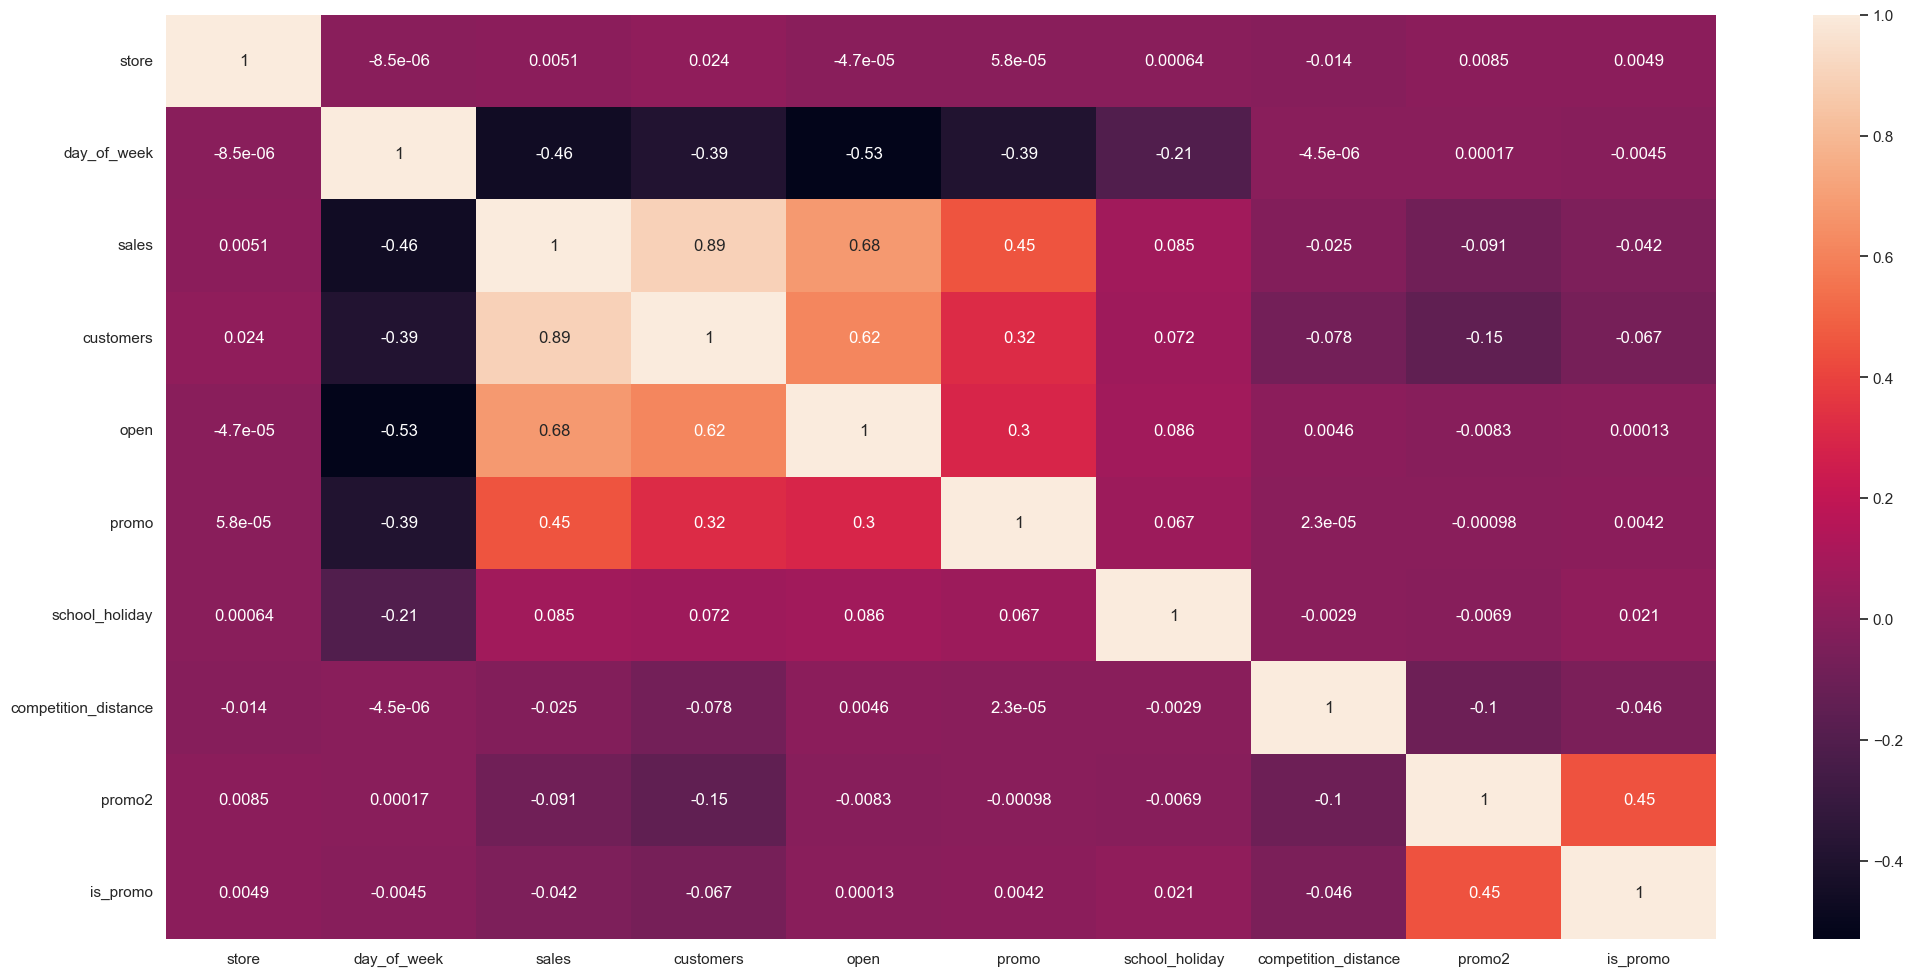

In [46]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

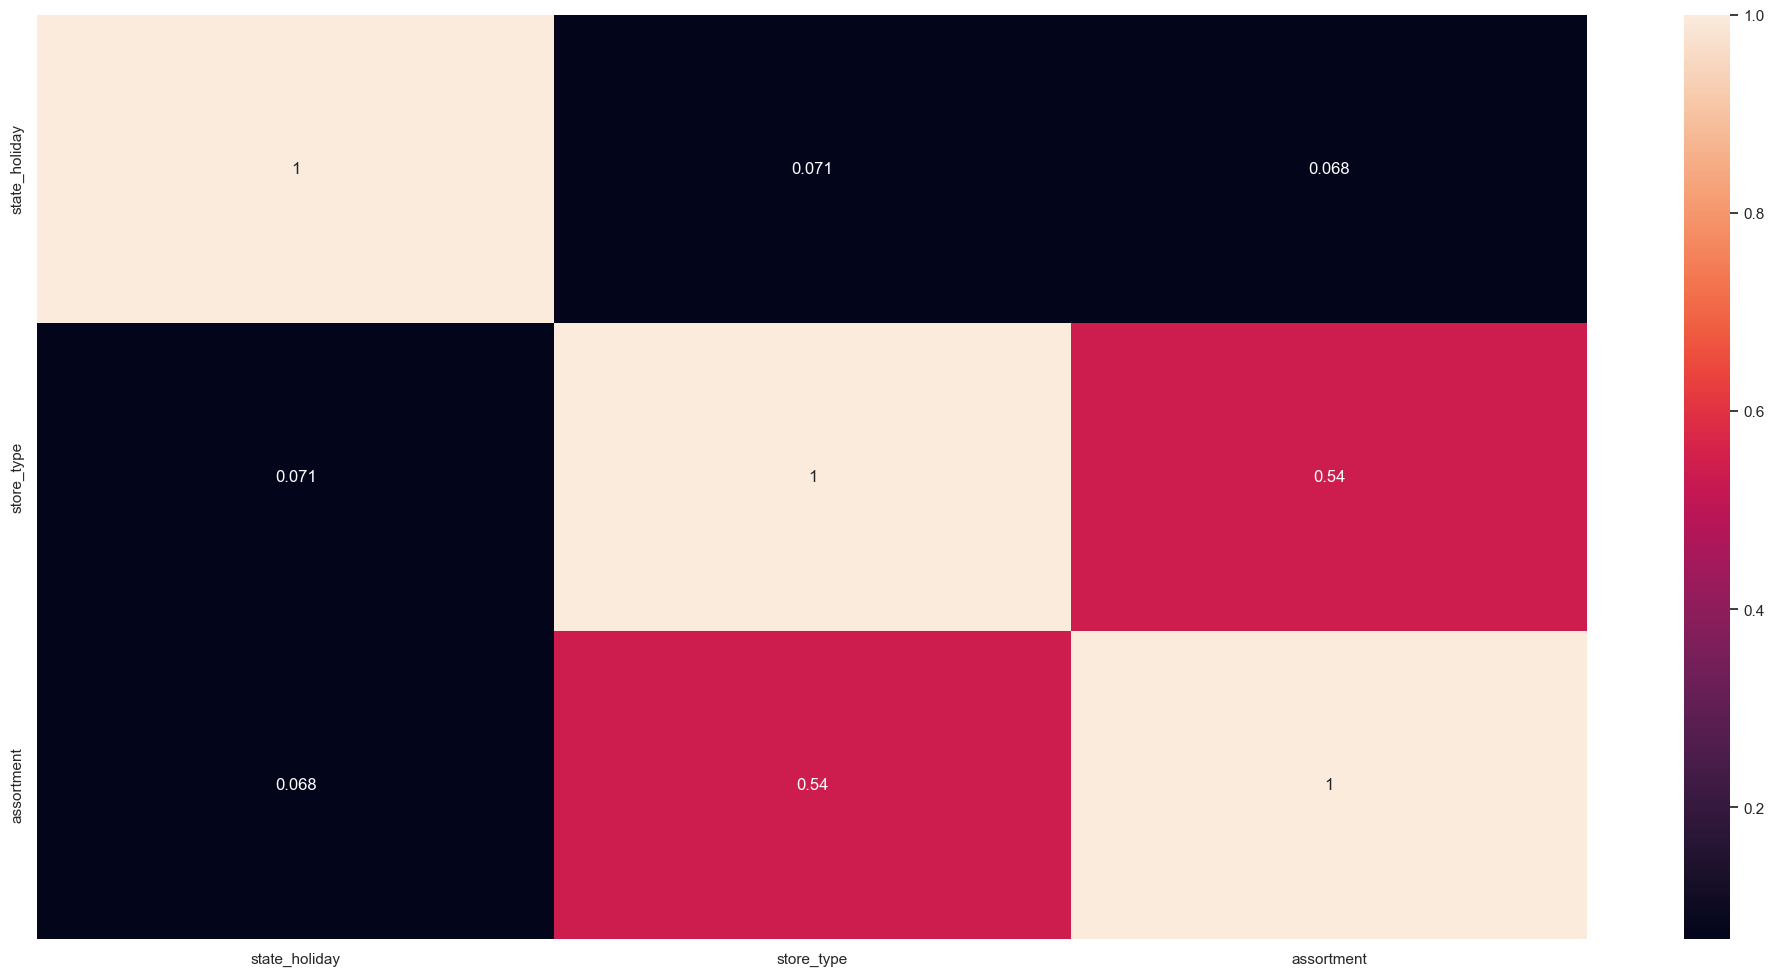

In [47]:
# Only categorical data
a = df4.select_dtypes( include='object' )

# Calculate Cramer V
a1 = cramer_v ( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v ( a['state_holiday'], a['store_type'] )
a3 = cramer_v ( a['state_holiday'], a['assortment'] )

a4 = cramer_v ( a['store_type'], a['state_holiday'] )
a5 = cramer_v ( a['store_type'], a['store_type'] )
a6 = cramer_v ( a['store_type'], a['assortment'] )

a7 = cramer_v ( a['assortment'], a['state_holiday'] )
a8 = cramer_v ( a['assortment'], a['store_type'] )
a9 = cramer_v ( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [ a1, a2, a3 ], 
               'store_type': [ a4, a5, a6 ], 
               'assortment': [ a7, a8, a9 ] 
               })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True);

# 5.0 DATA PREPARATION (Passo 5)

In [62]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [80]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Transformação

In [69]:
# day of week
# month
# day
# week of year